In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2023-10-19 21:38:32.724323: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-19 21:38:32.778890: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-19 21:38:33.002457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-19 21:38:33.002492: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-19 21:38:33.003727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
rd_state = 666

In [3]:
from sklearn.model_selection import train_test_split

all_data = pd.read_csv("train.csv")
challenge_input = pd.read_csv("test.csv")

# Normalize pixel values in [0,1]
all_data.loc[:, all_data.columns != 'label'] = all_data.loc[:, all_data.columns != 'label']/255
challenge_input = challenge_input/255

all_input = all_data.drop('label', axis=1)
all_labels = all_data['label'].copy()

# Extract a validation set
train_input, validate_input, train_labels, validate_labels = train_test_split(all_input, all_labels, test_size=0.05, random_state=rd_state)

# Extract a testing set
train_input, test_input, train_labels, test_labels = train_test_split(train_input, train_labels, test_size=0.10, random_state=rd_state)

train_both = train_input.copy()
train_both['label'] = train_labels

# Sanity check
print("All data:  %s" % (all_data.shape,))
print("All input: %s" % (all_input.shape,))
print("Training:  %s" % (train_input.shape,))
print("Test set:  %s" % (test_input.shape,))
print("Validate:  %s" % (validate_input.shape,))
print("Challenge: %s" % (challenge_input.shape,))

All data:  (42000, 785)
All input: (42000, 784)
Training:  (35910, 784)
Test set:  (3990, 784)
Validate:  (2100, 784)
Challenge: (28000, 784)


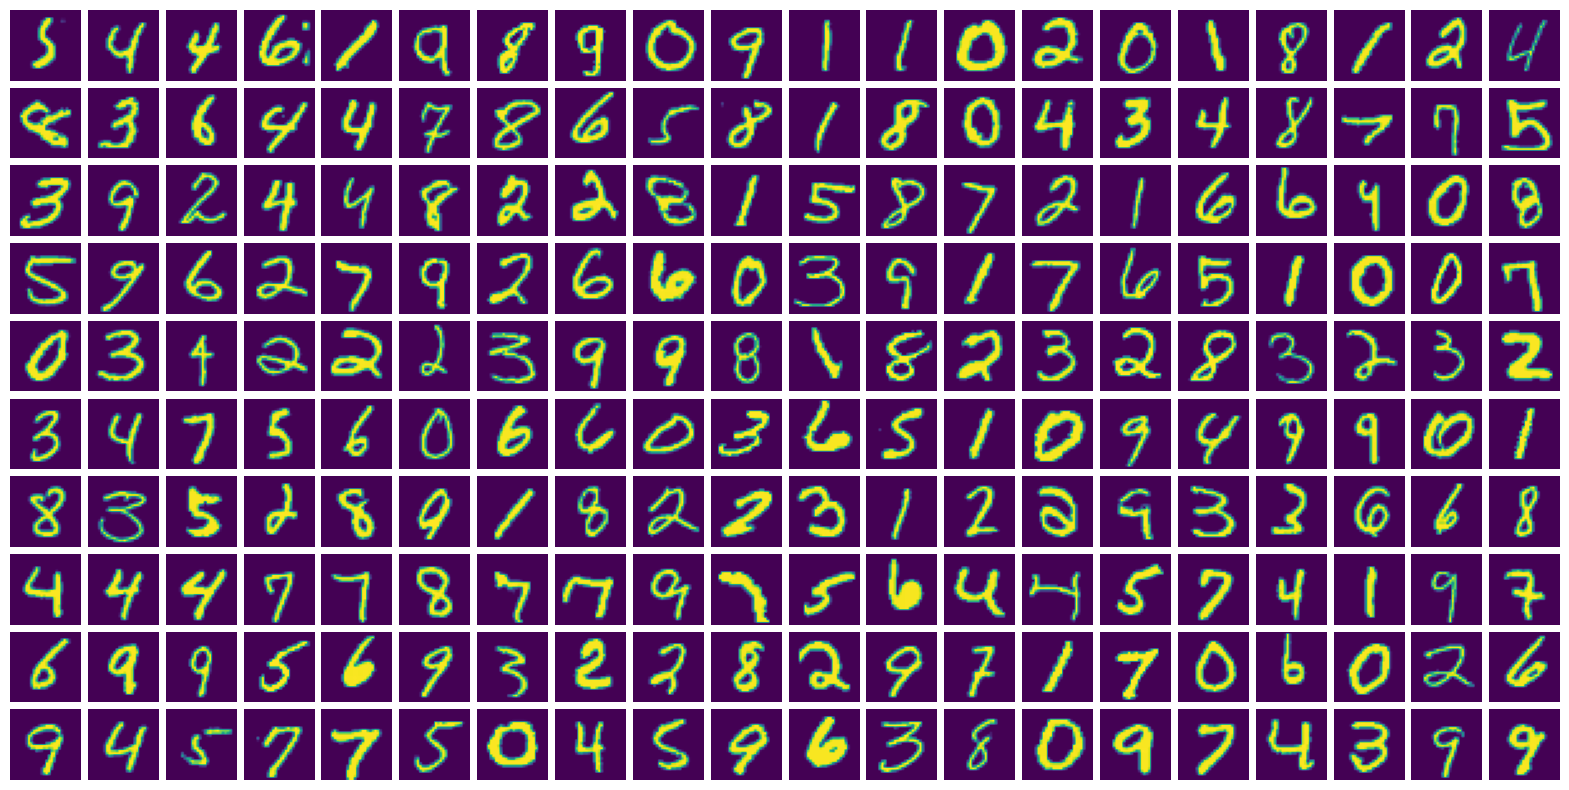

In [4]:
def show_digits(inp, X, Y):
    fX = 20
    fY = int(fX*Y/X)

    figure, axis = plt.subplots(max(Y, 2), max(X, 2), figsize=(fX,fY))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    for x in range(X):
        for y in range(Y):
            axis[y, x].imshow(inp.iloc[y*X+x].to_numpy().reshape(28, 28))
            axis[y, x].axis('off')

# Let's peek at some random digits
show_digits(train_input, 20, 10)

In [7]:
# Train a predictor

# Sequential version
#model = tf.keras.Sequential([
#    tf.keras.layers.Flatten(input_shape=(784,)),
#    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dense(10)
#])

# Functional version
inputs = tf.keras.Input(shape=(784,))
hidden = tf.keras.layers.Dense(128, activation="relu")(inputs)
outputs = tf.keras.layers.Dense(10)(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_input, train_labels, epochs=10)

test_loss, test_acc = model.evaluate(test_input,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.3167 - accuracy: 0.9093
Epoch 2/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.1456 - accuracy: 0.9581
Epoch 3/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.1012 - accuracy: 0.9707
Epoch 4/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0736 - accuracy: 0.9784
Epoch 5/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0585 - accuracy: 0.9826
Epoch 6/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0447 - accuracy: 0.9864
Epoch 7/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0347 - accuracy: 0.9889
Epoch 8/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0271 - accuracy: 0.9922
Epoch 9/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.0218 - accuracy: 0.9938
Epoch 10/10
1123/1123 [==============================] - 2s 2ms/step - loss: 0.017

In [8]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(challenge_input)

challenge_result = challenge_input.copy()
challenge_result["Label"] = np.argmax(predictions, axis=1)
challenge_result["ImageId"] = range(1, len(challenge_result) + 1)
challenge_result.to_csv("cpitrat_tf_result.csv", columns=["ImageId", "Label"], index=False)

875/875 [==============================] - 1s 566us/step


In [9]:
# One-hot-encoding of labels
all_labels_ohe = pd.get_dummies(data=all_labels, columns=["label"]) * 1.0

In [10]:
# Let's build an autoencoder

# Both input & output
n_input = 28*28
# Encoder structure
n_encoder = 200
# Encoding
n_trained_latent = 10
n_free_latent = 2
n_latent = n_trained_latent + n_free_latent
# Decoder structure
n_decoder = 200

# Sequential version
#enc_dec = tf.keras.Sequential([
#    tf.keras.layers.Dense(n_encoder, activation='relu'),
#    tf.keras.layers.Dense(n_latent, activation='relu'),
#    tf.keras.layers.Dense(n_decoder, activation='relu'),
#    tf.keras.layers.Dense(n_input),
#])

# Functional version
inputs = tf.keras.Input(shape=(n_input,))
encoder = tf.keras.layers.Dense(n_encoder, activation="relu")(inputs)
trained_latent = tf.keras.layers.Dense(n_trained_latent, activation="relu")(encoder)
free_latent = tf.keras.layers.Dense(n_free_latent, activation="relu")(encoder)
latent = tf.keras.layers.concatenate([trained_latent, free_latent])
decoder = tf.keras.layers.Dense(n_decoder, activation="relu")(latent)
outputs = tf.keras.layers.Dense(n_input)(decoder)

enc_dec_train = tf.keras.Model(inputs=inputs, outputs=[outputs, trained_latent])

enc_dec_train.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

enc_dec_train.fit(all_input, [all_input, all_labels_ohe], epochs=100)

enc_dec = tf.keras.Model(inputs=inputs, outputs=outputs)
enc_dec.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

test_loss, test_acc = enc_dec.evaluate(challenge_input,  challenge_input, verbose=2)

print('\nTest loss: %s - Test accuracy: %s' % (test_loss, test_acc))

print(enc_dec.summary())

Epoch 1/100
1313/1313 [==============================] - 3s 2ms/step - loss: 0.0931 - dense_8_loss: 0.0470 - dense_5_loss: 0.0460 - dense_8_root_mean_squared_error: 0.2168 - dense_5_root_mean_squared_error: 0.2146
Epoch 2/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0748 - dense_8_loss: 0.0398 - dense_5_loss: 0.0350 - dense_8_root_mean_squared_error: 0.1995 - dense_5_root_mean_squared_error: 0.1871
Epoch 3/100
1313/1313 [==============================] - 6s 4ms/step - loss: 0.0642 - dense_8_loss: 0.0377 - dense_5_loss: 0.0266 - dense_8_root_mean_squared_error: 0.1941 - dense_5_root_mean_squared_error: 0.1630
Epoch 4/100
1313/1313 [==============================] - 6s 4ms/step - loss: 0.0620 - dense_8_loss: 0.0367 - dense_5_loss: 0.0254 - dense_8_root_mean_squared_error: 0.1915 - dense_5_root_mean_squared_error: 0.1593
Epoch 5/100
1313/1313 [==============================] - 6s 4ms/step - loss: 0.0608 - dense_8_loss: 0.0359 - dense_5_loss: 0.0249 - dense_8_root

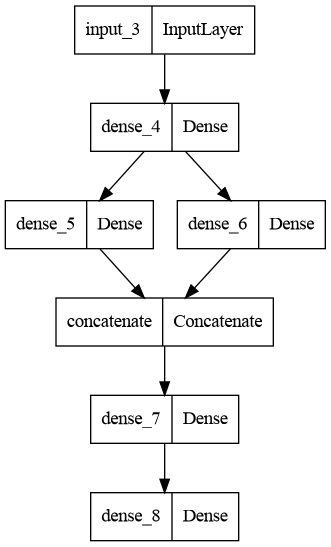

In [11]:
tf.keras.utils.plot_model(enc_dec)

875/875 [==============================] - 1s 733us/step


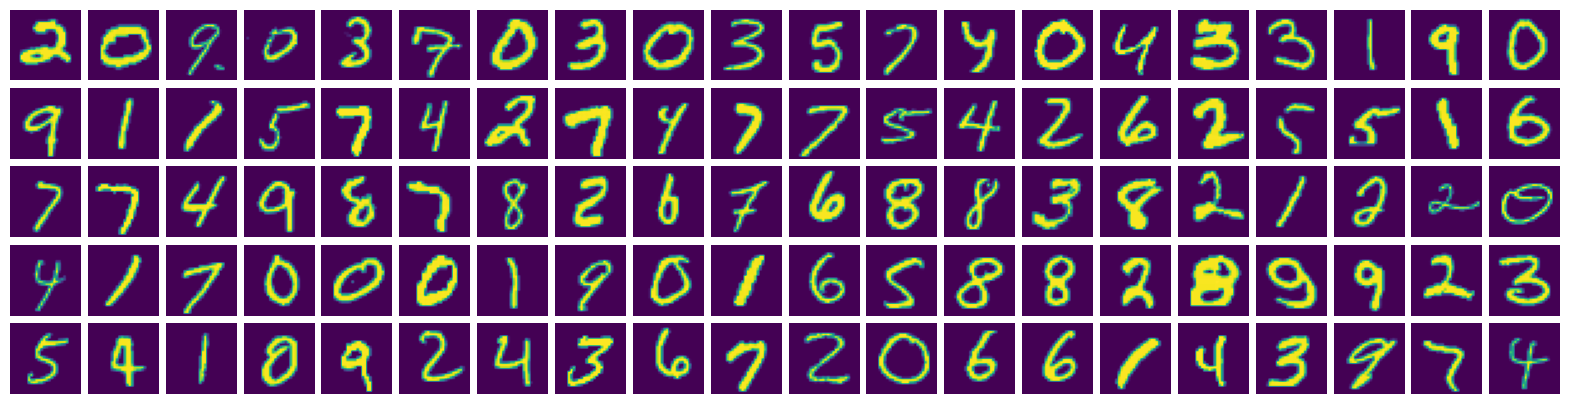

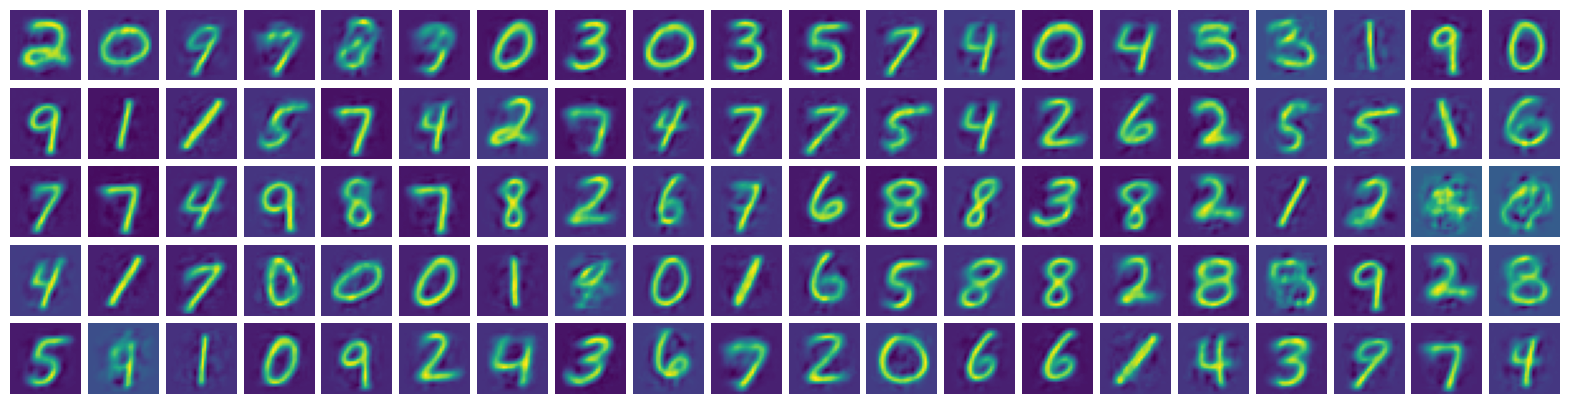

In [12]:
show_digits(challenge_input, 20, 5)
challenge_decoded = enc_dec.predict(challenge_input)
show_digits(pd.DataFrame(challenge_decoded), 20, 5)

In [13]:
# Extract the encoder and decoder
""" # This is the sequential version
encoder = tf.keras.Sequential()
decoder = tf.keras.Sequential()

for layer in enc_dec.layers[:2]:
  encoder.add(layer)

for layer in enc_dec.layers[2:]:
  decoder.add(layer)

# Print summary:
encoder.build((1, n_input))
decoder.build((1, n_latent))
print(encoder.summary())
print(decoder.summary())
"""

# This is the functional version
encoder = tf.keras.Model(inputs=inputs, outputs=latent)
decoder = tf.keras.Model(inputs=latent, outputs=outputs)

875/875 [==============================] - 0s 545us/step


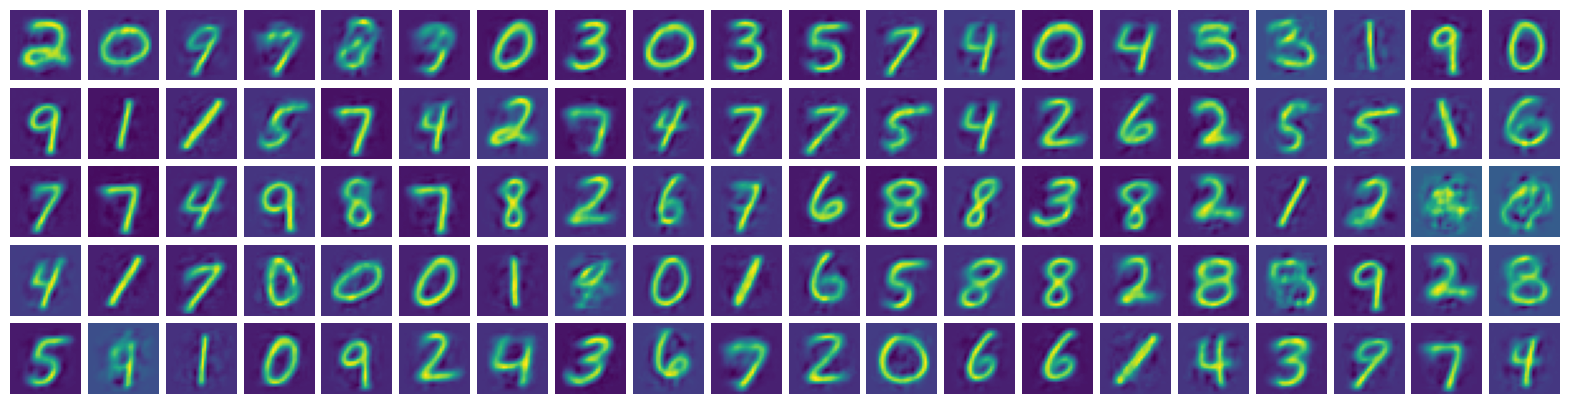

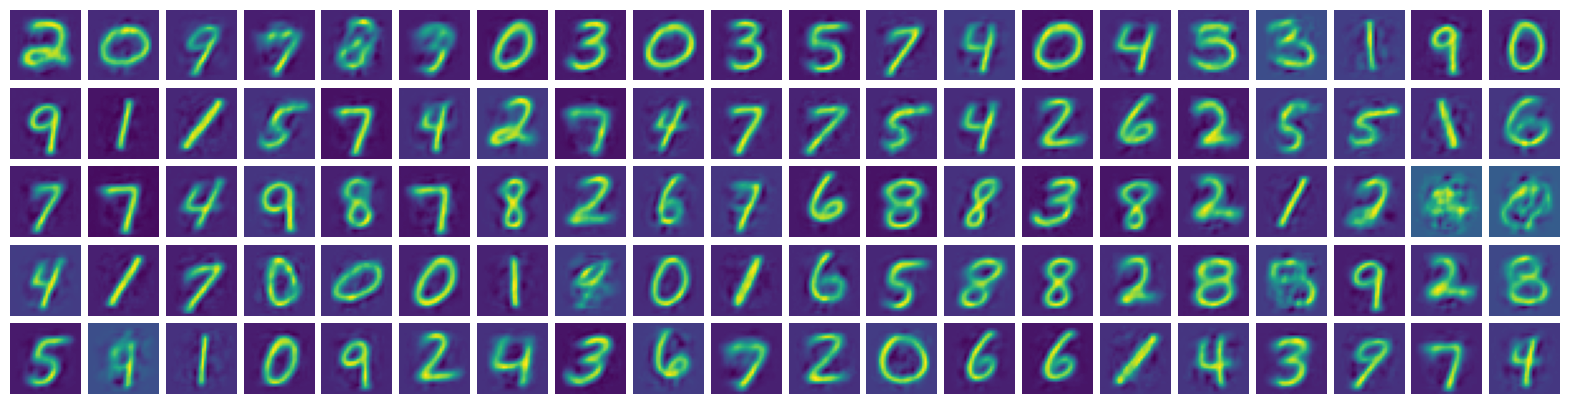

In [14]:
show_digits(pd.DataFrame(challenge_decoded), 20, 5)

challenge_decoded2 = decoder.predict(encoder.predict(challenge_input))
show_digits(pd.DataFrame(challenge_decoded2), 20, 5)

1123/1123 [==============================] - 1s 561us/step


'0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] (+/- [0.07602303 0.029067   0.00250231 0.         0.         0.01337114\n 0.05305292 0.         0.03326578 0.00294103 0.52627307 0.70063162])'

'1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1.] (+/- [0.         0.08513157 0.00175497 0.         0.         0.00473532\n 0.0043488  0.         0.02079909 0.         1.09743118 0.46817917])'

'2 -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.] (+/- [0.01824255 0.03841899 0.14028867 0.         0.00542849 0.01340047\n 0.02258674 0.         0.01324911 0.         0.66984946 0.62185109])'

'3 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.] (+/- [0.0085742  0.04717864 0.02021484 0.         0.         0.05621611\n 0.02874403 0.         0.02588887 0.01654051 0.4567011  0.41587374])'

'4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.] (+/- [0.01141302 0.03848698 0.00395113 0.         0.10395912 0.00971217\n 0.04657291 0.         0.00231194 0.01646812 0.74333894 0.44845095])'

'5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.] (+/- [0.01305013 0.04362592 0.0023353  0.         0.00879205 0.12408099\n 0.03071257 0.         0.02124057 0.00322131 0.90600145 0.53291875])'

'6 -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] (+/- [0.02696784 0.03232719 0.0077304  0.         0.01098096 0.01980259\n 0.11639152 0.         0.02191235 0.         0.6873849  0.48272967])'

'7 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] (+/- [0.00140743 0.03515994 0.02268934 0.         0.01853572 0.0128354\n 0.00786779 0.         0.00728227 0.02660636 0.76713908 0.31632531])'

'8 -> [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.] (+/- [0.01016504 0.03866337 0.00947596 0.         0.00168797 0.04660708\n 0.03165519 0.         0.08271121 0.00119701 0.59864938 0.38440269])'

'9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] (+/- [0.01385677 0.0319919  0.00570531 0.         0.01872655 0.03637436\n 0.0323991  0.         0.01914709 0.10942461 0.66687071 0.34596822])'

'Encoded values between 0.0 and 4.5741053'

'std between 0.0 and 1.0974311828613281'

1/1 [==============================] - 0s 23ms/step


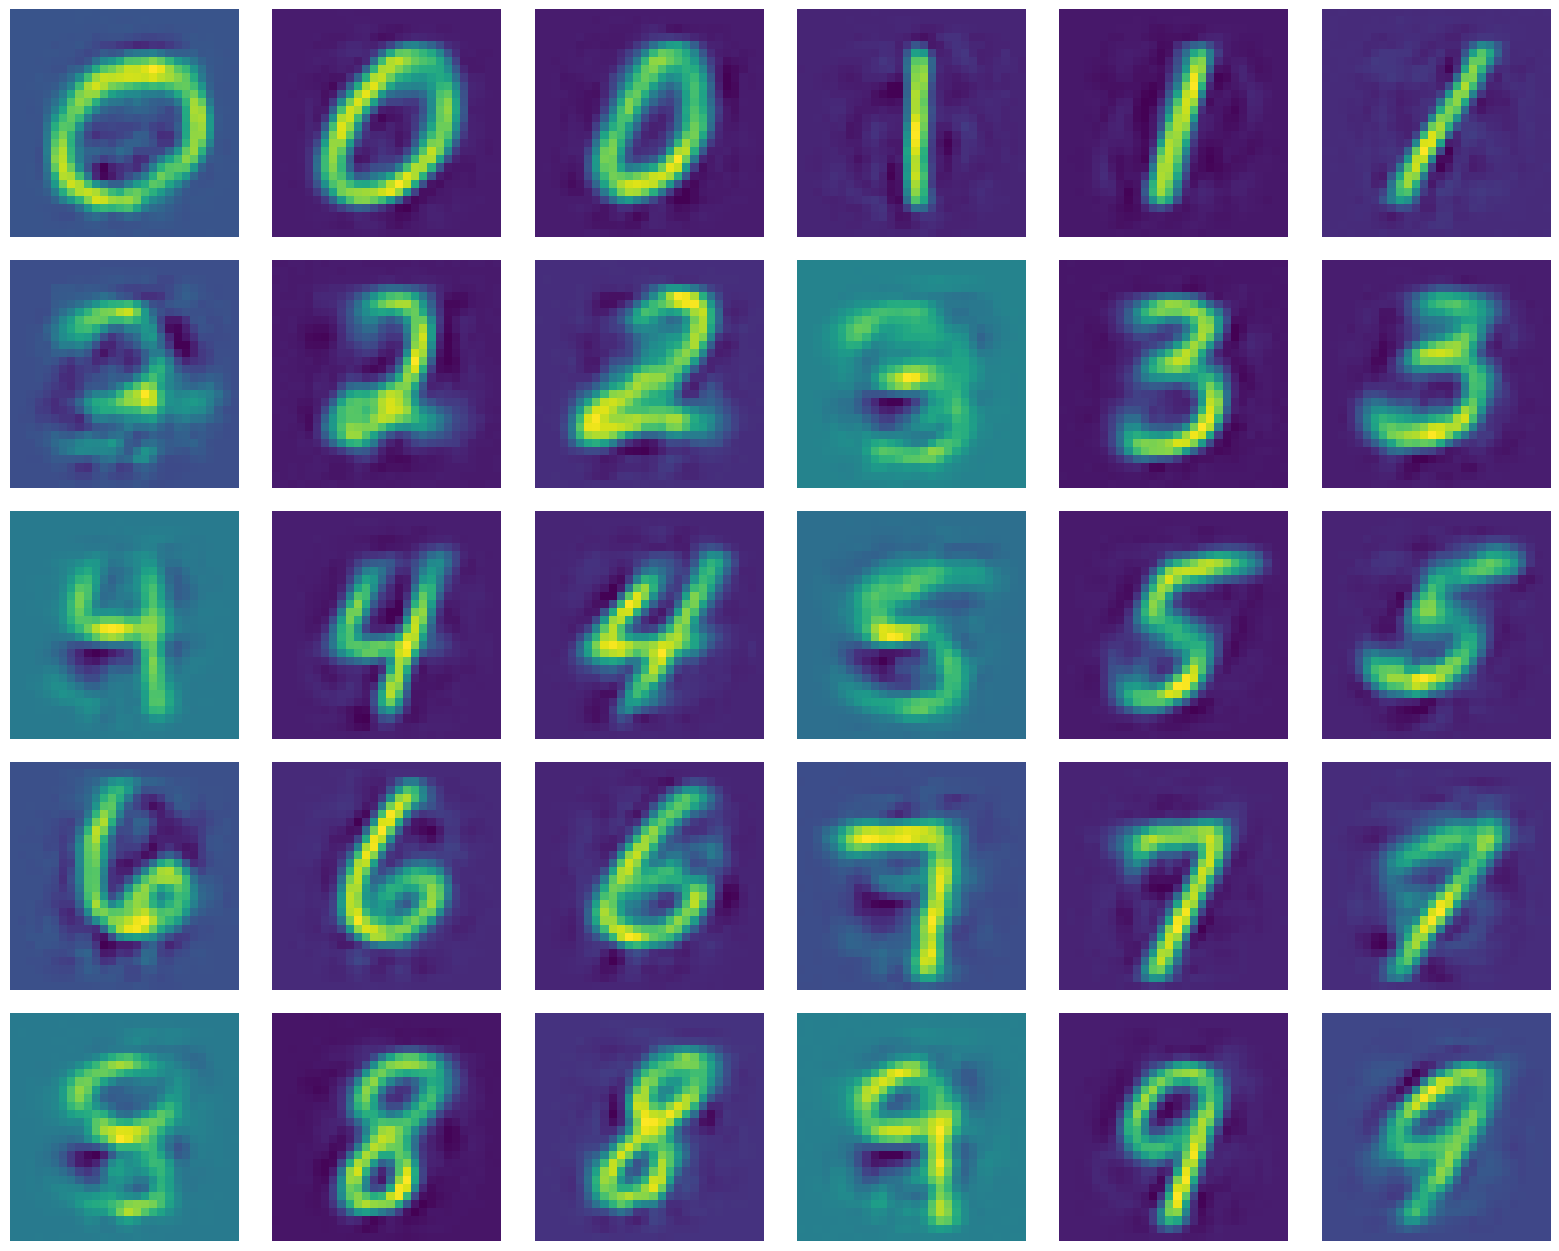

In [15]:
train_encoded = encoder.predict(train_input)

means = []
stds = []
for i in range(10):
    mean = pd.DataFrame(train_encoded[train_both['label'] == i]).describe().loc['mean'].to_numpy()
    std = pd.DataFrame(train_encoded[train_both['label'] == i]).describe().loc['std'].to_numpy()
    display("%s -> %s (+/- %s)" % (i, mean.round(), std))
    stds.extend(std)
    means.append(mean-std)
    means.append(mean)
    means.append(mean+std)

means = np.asarray(means)

display("Encoded values between %s and %s" % (min(train_encoded.flatten()), max(train_encoded.flatten())))
display("std between %s and %s" % (min(stds), max(stds)))

decoded_means = decoder.predict(means)
show_digits(pd.DataFrame(decoded_means), 6, 5)

4/4 [==============================] - 0s 992us/step


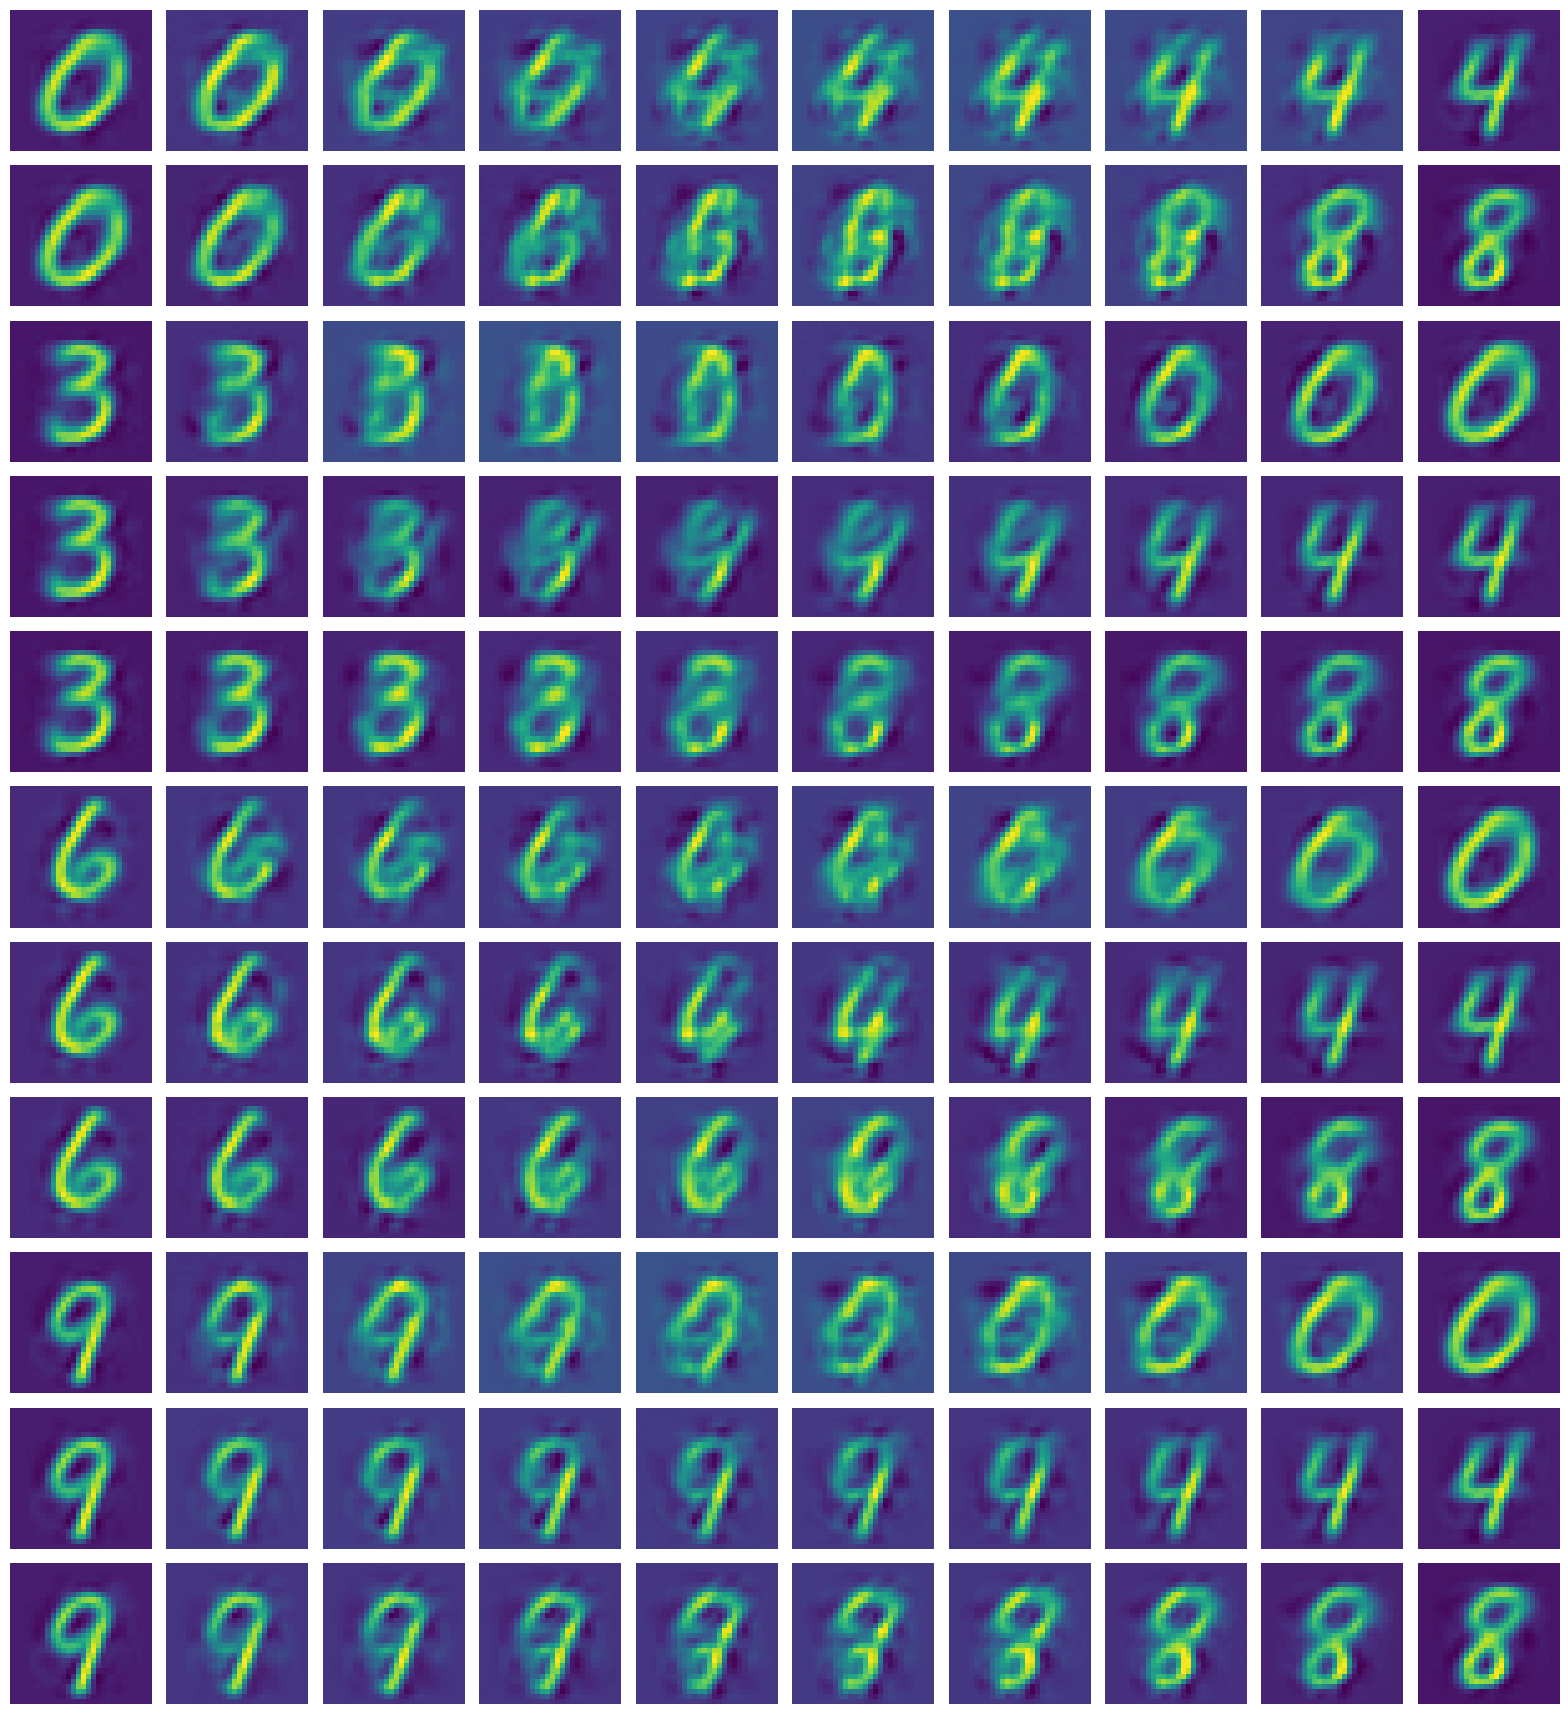

In [16]:
# Morphing one digit into another

steps = 10

def morph(fr, to, steps):
    d = [(x-y)/(steps-1) for (x,y) in zip(to, fr)]
    res = []
    for i in range(steps):
        res.append([x+i*y for (x,y) in zip(fr,d)])
    return res

enc = []
for i in range(10):
    enc.append(means[3*i+1])
    
myencoded = \
  morph(enc[0], enc[6], steps) + \
  morph(enc[0], enc[5], steps) + \
  morph(enc[1], enc[7], steps) + \
  morph(enc[1], enc[8], steps)

myencoded = []
for i in range(0, 10, 3):
    for j in range(0, 10, 4):
        if i == j:
            continue
        myencoded.extend(morph(enc[i], enc[j], steps))

decoded_myencoded = decoder.predict(myencoded)
show_digits(pd.DataFrame(decoded_myencoded), steps, len(myencoded)//steps)

1/1 [==============================] - 0s 11ms/step


array([[ 0.00406516,  0.00981062, -0.00370073, ...,  0.00266465,
        -0.00433459,  0.02936881],
       [-0.00131799, -0.00190989,  0.0027581 , ...,  0.00215551,
         0.00301231,  0.00866774],
       [-0.00506861, -0.00369129,  0.00698522, ..., -0.01079098,
        -0.00179036,  0.01597957],
       ...,
       [-0.00203479, -0.00339314,  0.00324133, ..., -0.00121721,
         0.00039353,  0.01095382],
       [-0.00165938, -0.00029079,  0.00290997, ..., -0.00110317,
        -0.00072317,  0.00424124],
       [ 0.00103511,  0.00308882, -0.00116537, ...,  0.00615712,
        -0.00071593, -0.00135282]], dtype=float32)

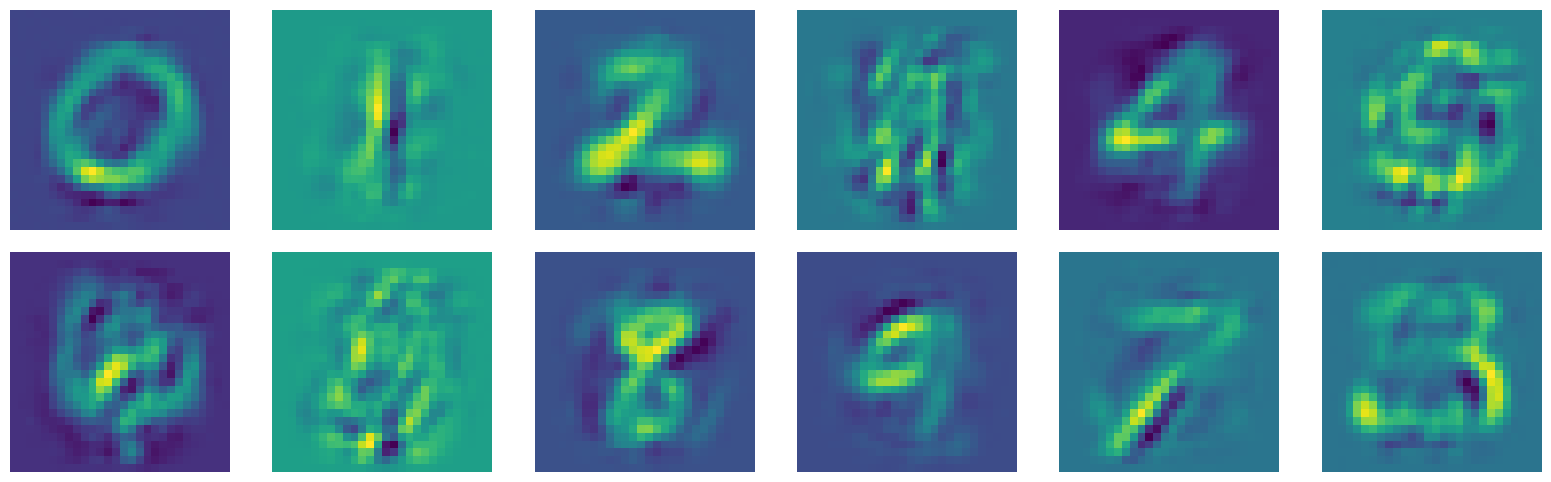

In [35]:
basis = decoder.predict(10*np.identity(n_latent))
show_digits(pd.DataFrame(basis), 6, 2)

In [41]:
def combis(n, vals):
    result = []
    if n == 1:
        return [[x] for x in vals]
    for l in combis(n-1, vals):
        for v in vals:
            result.append(l + [v])
    return result

2/2 [==============================] - 0s 2ms/step


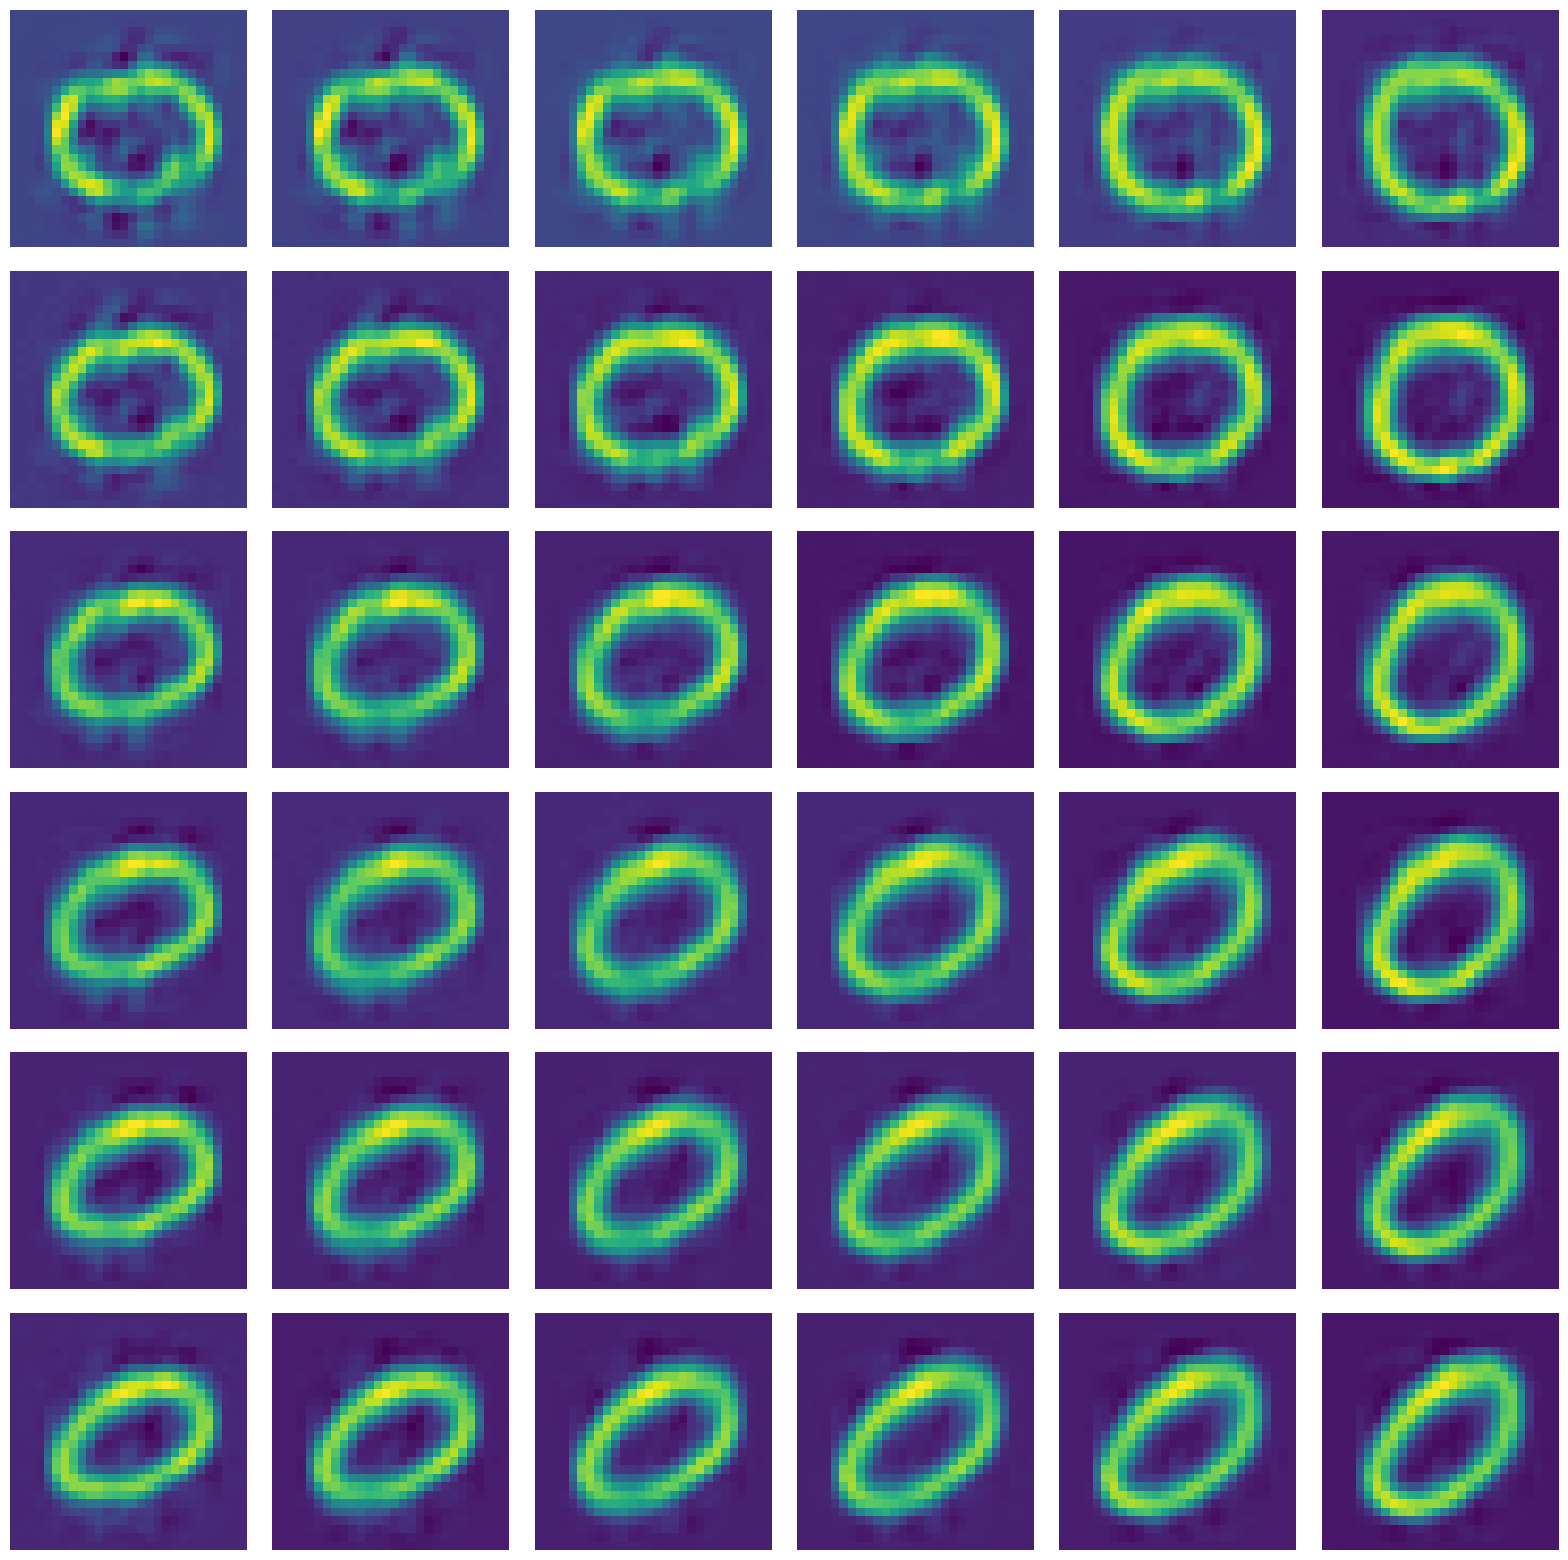

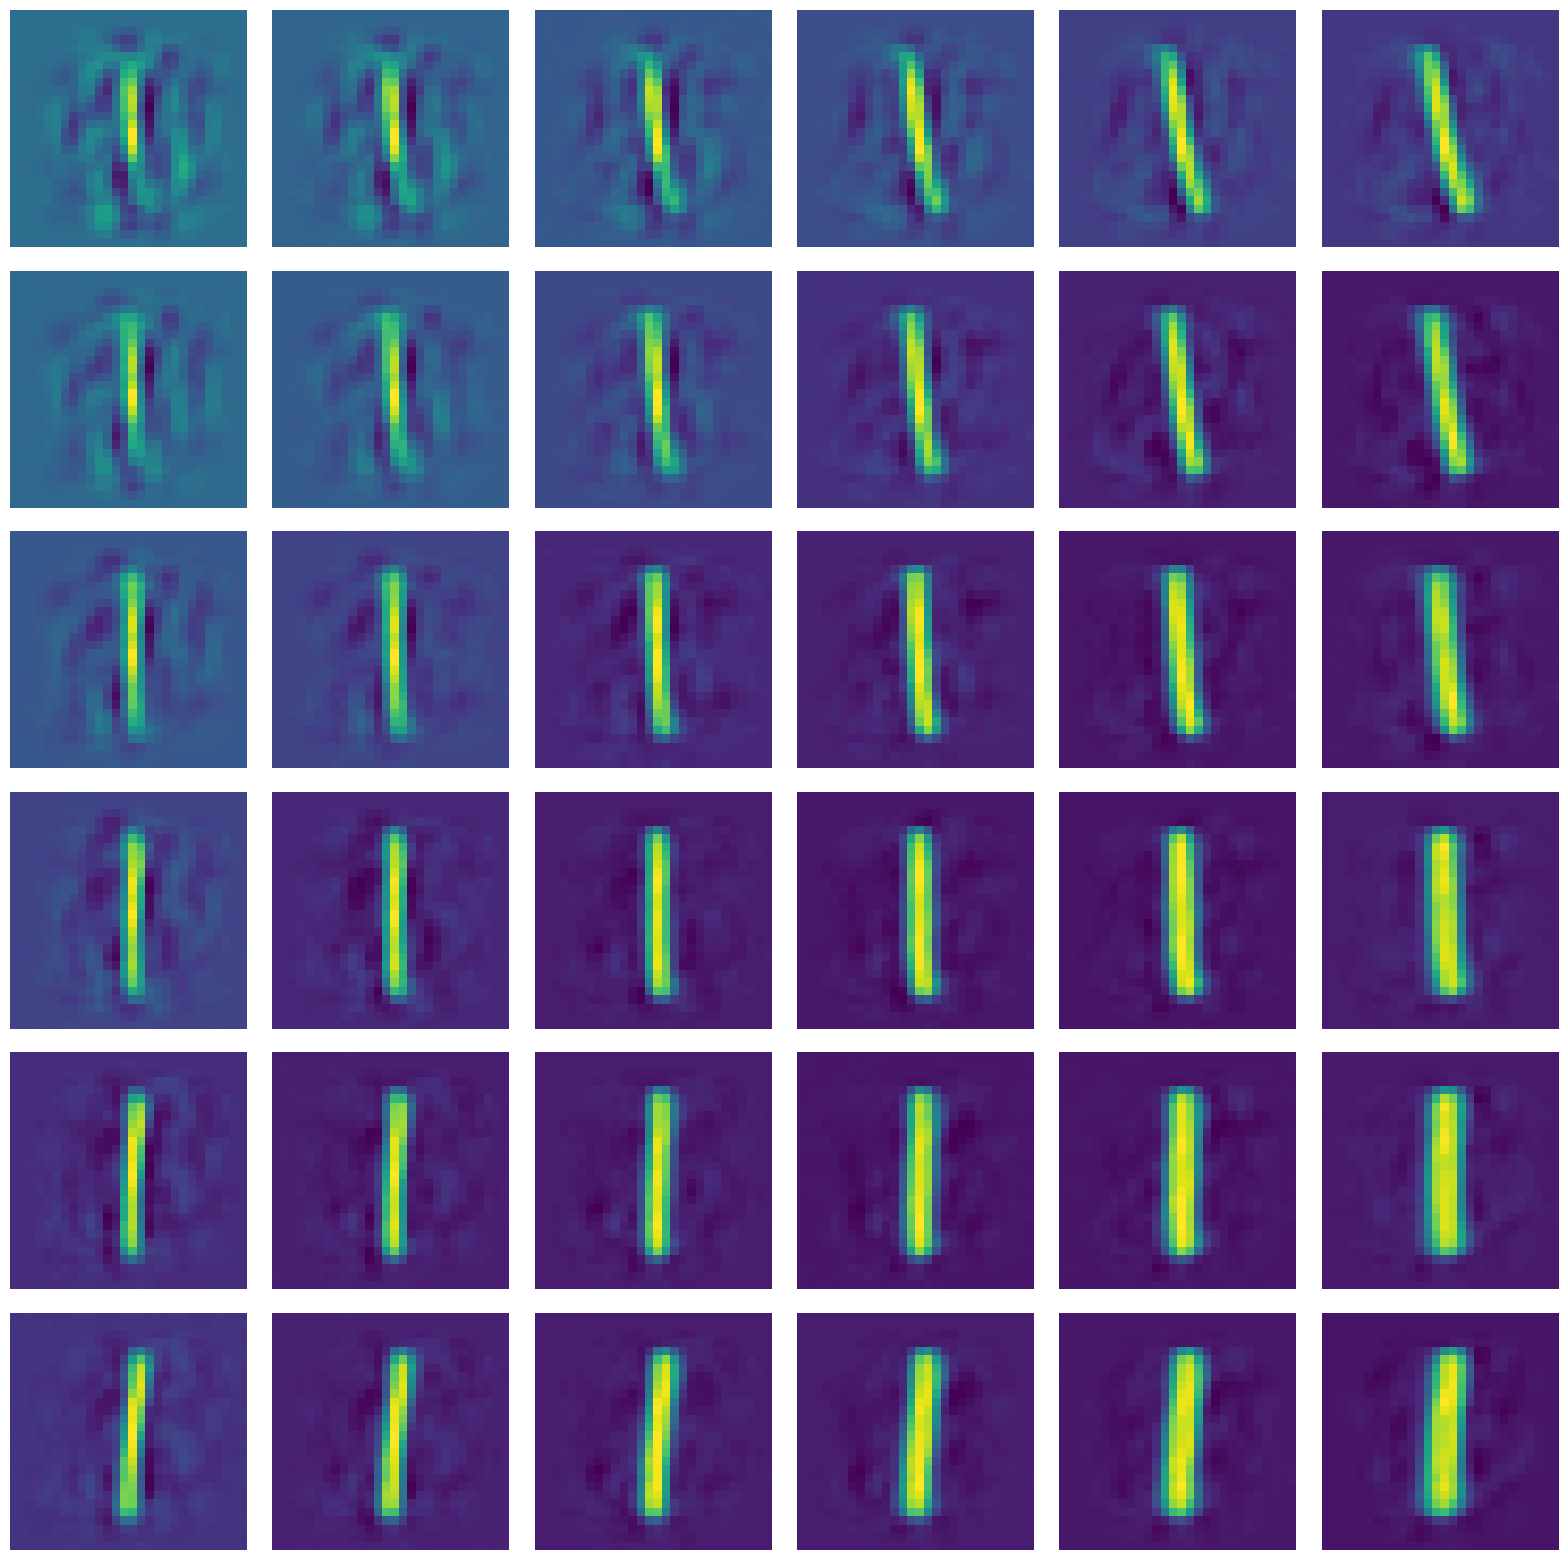

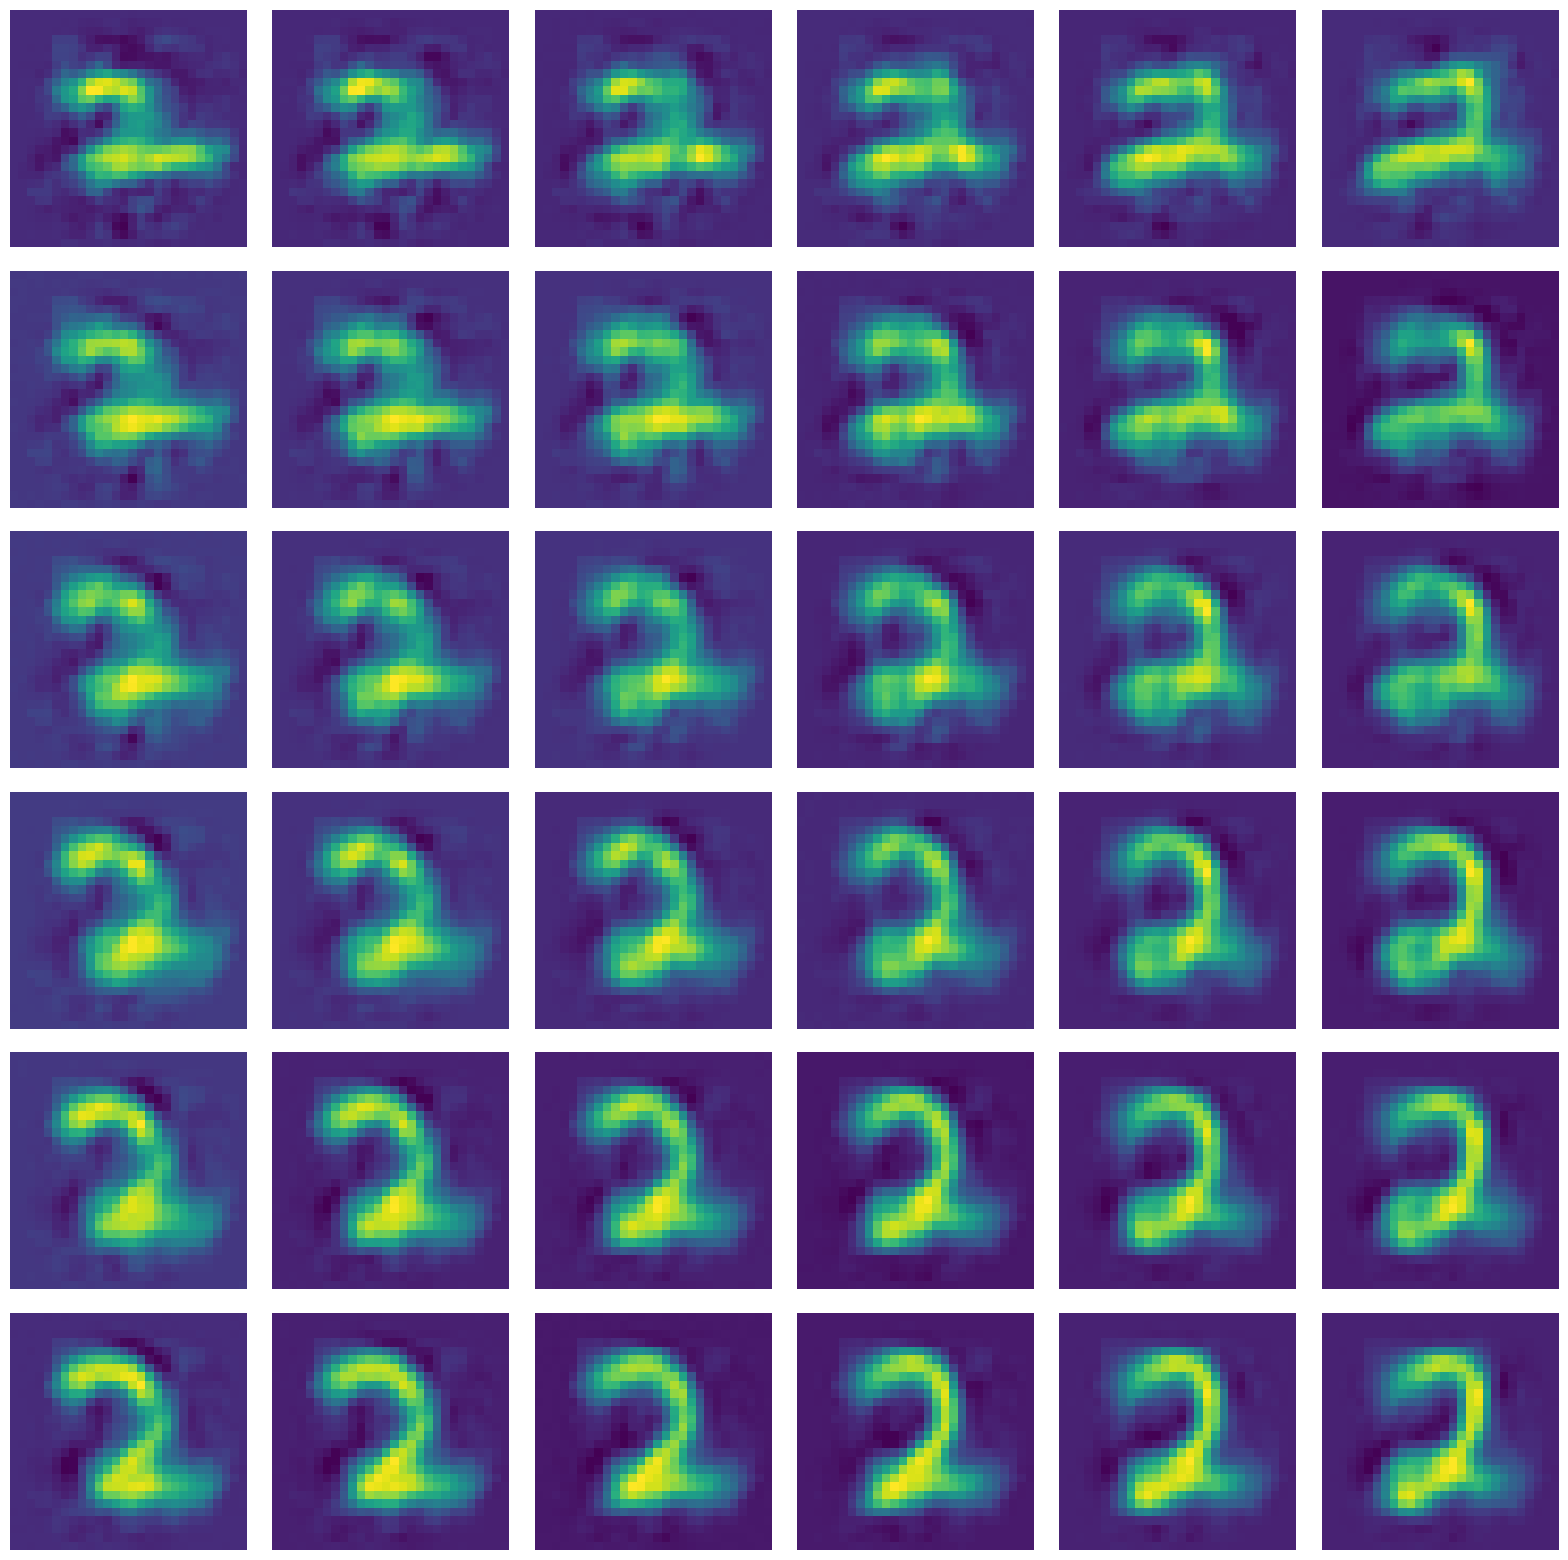

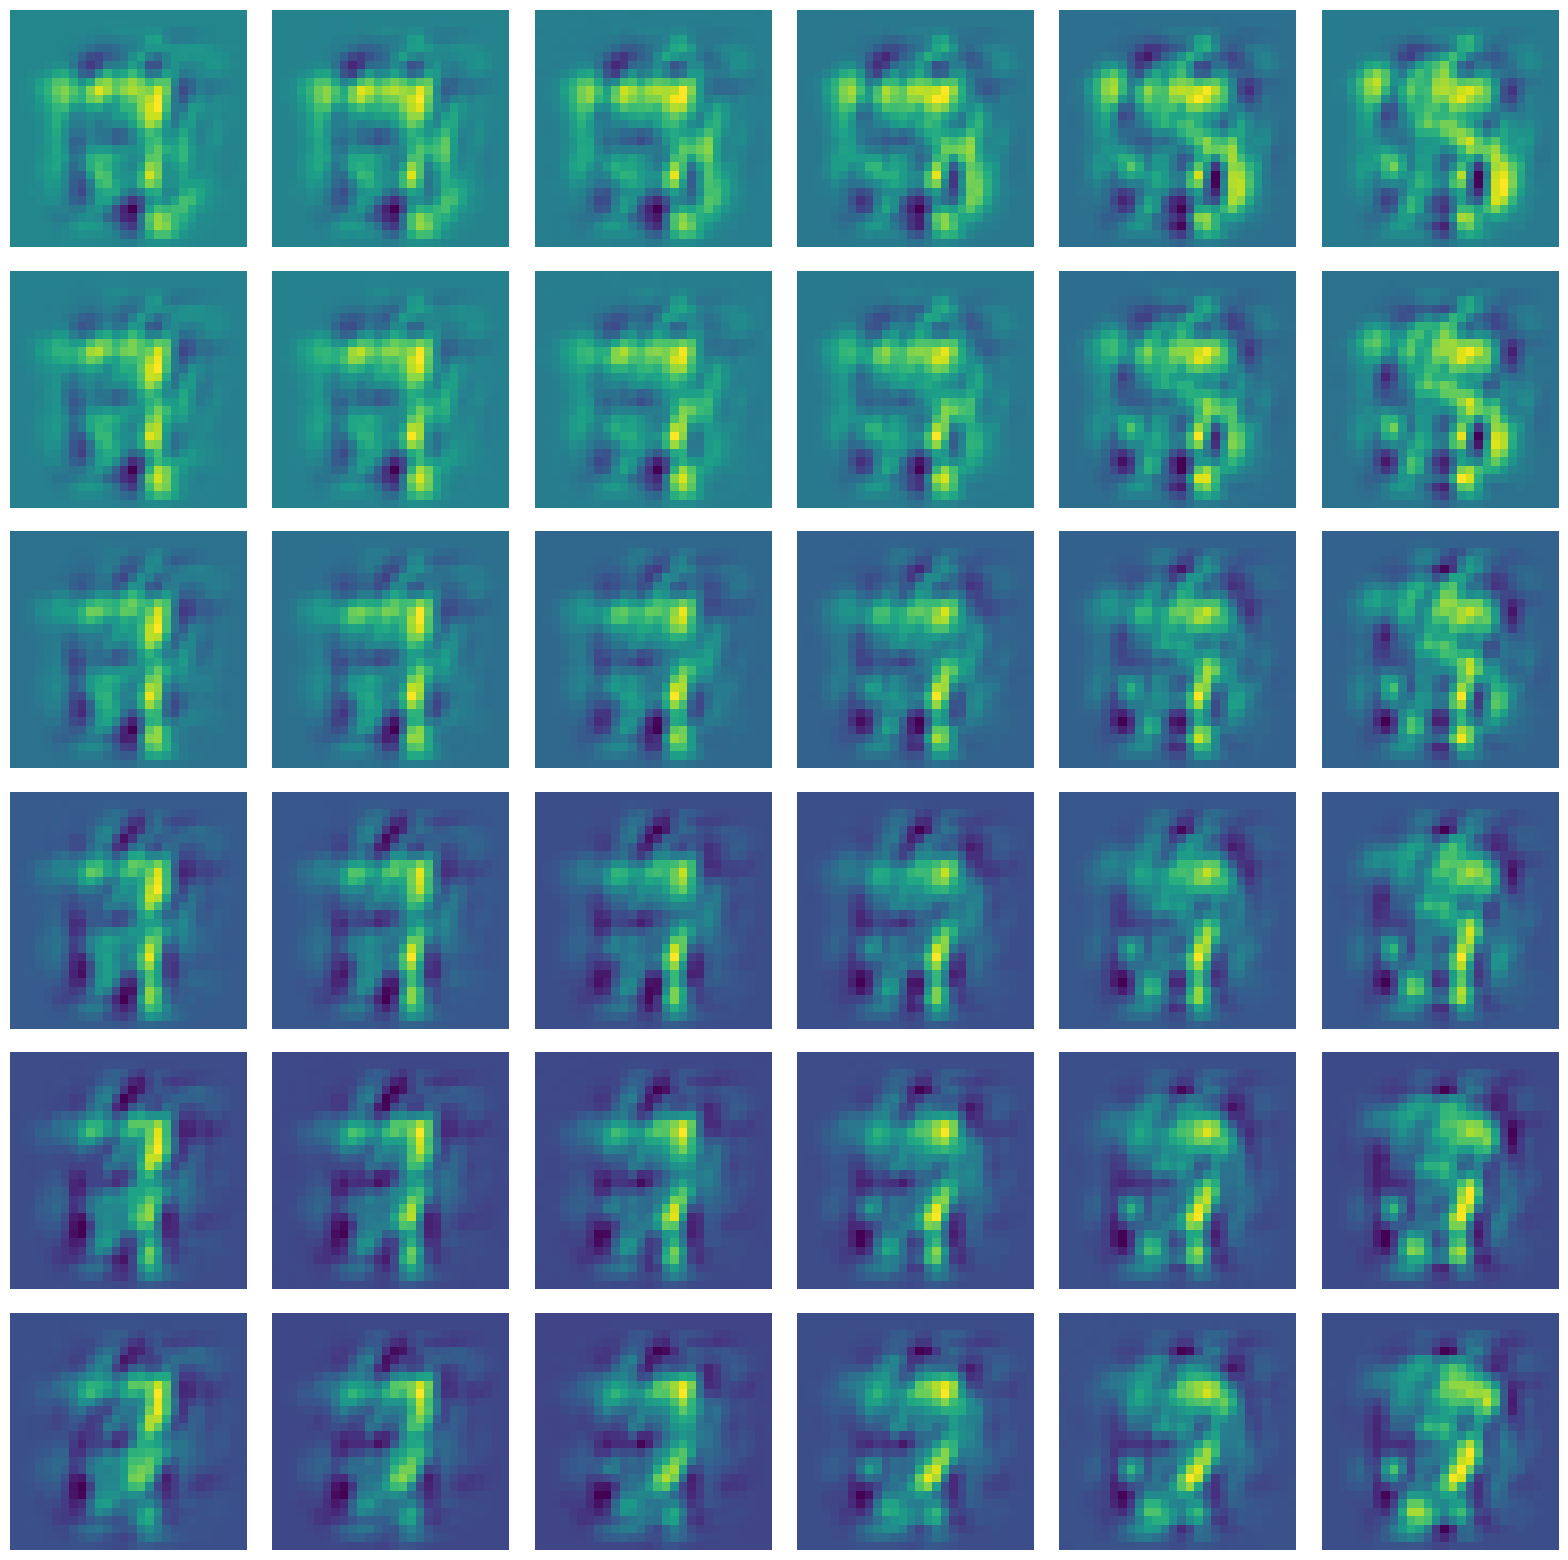

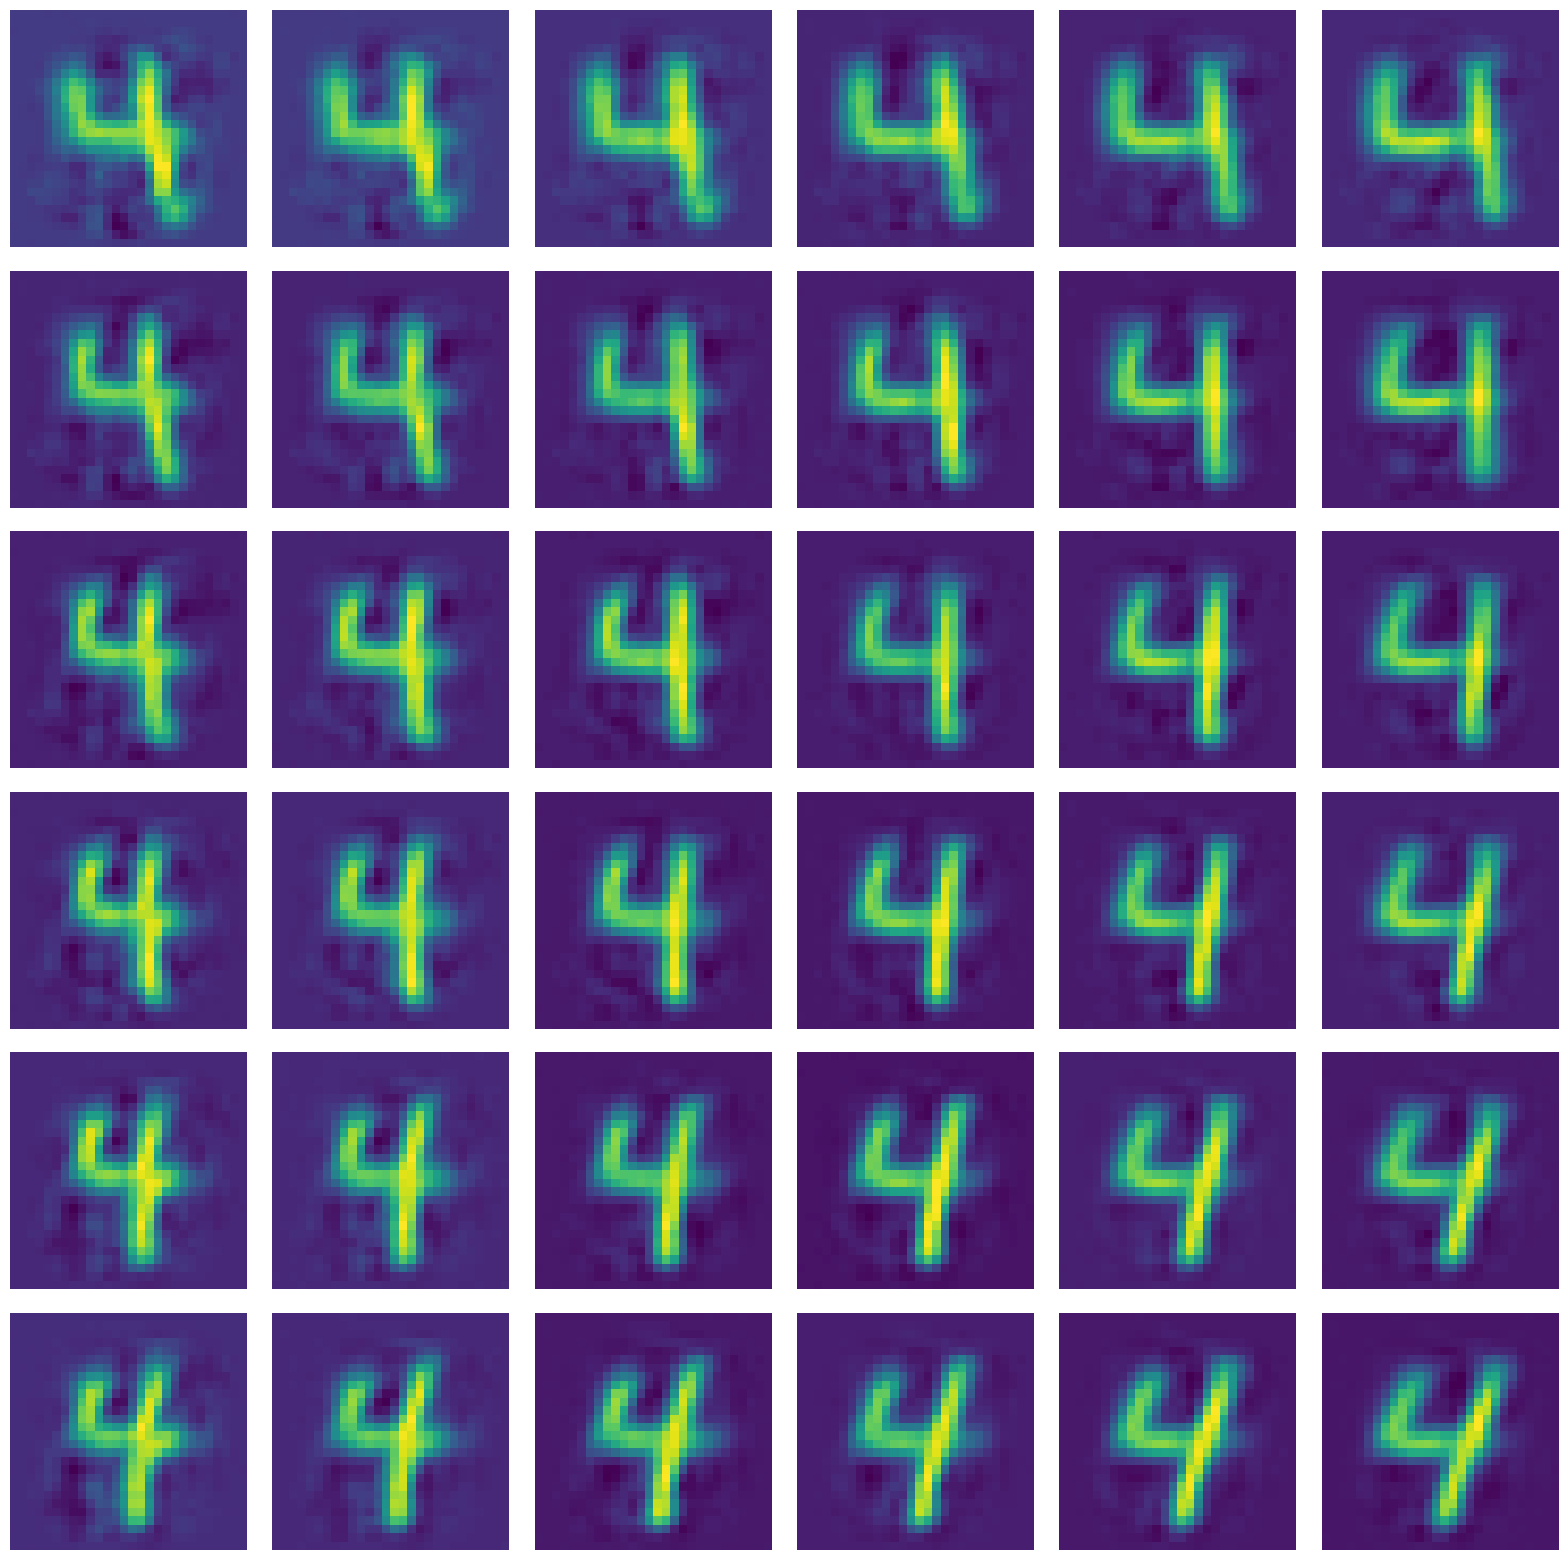

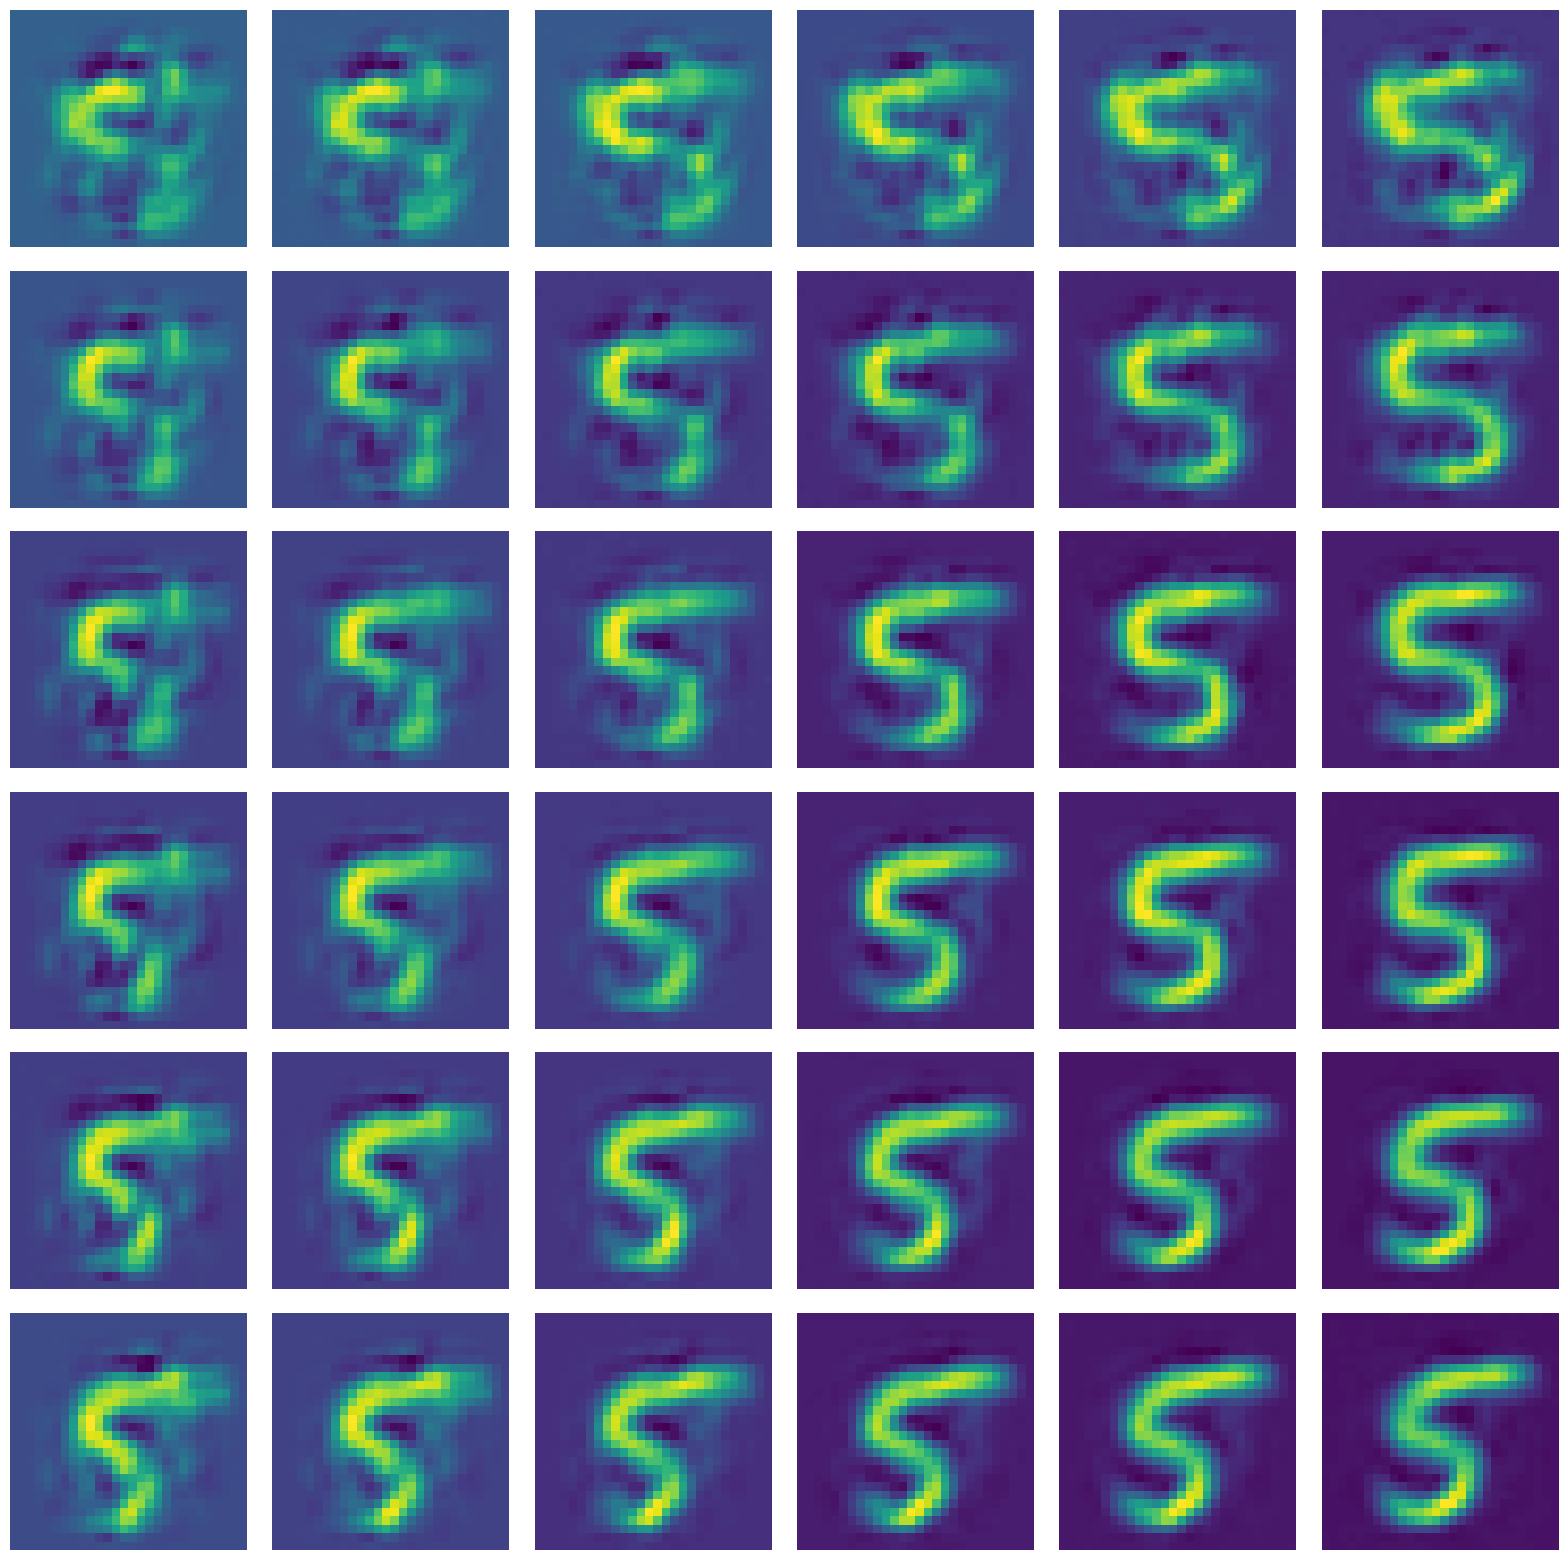

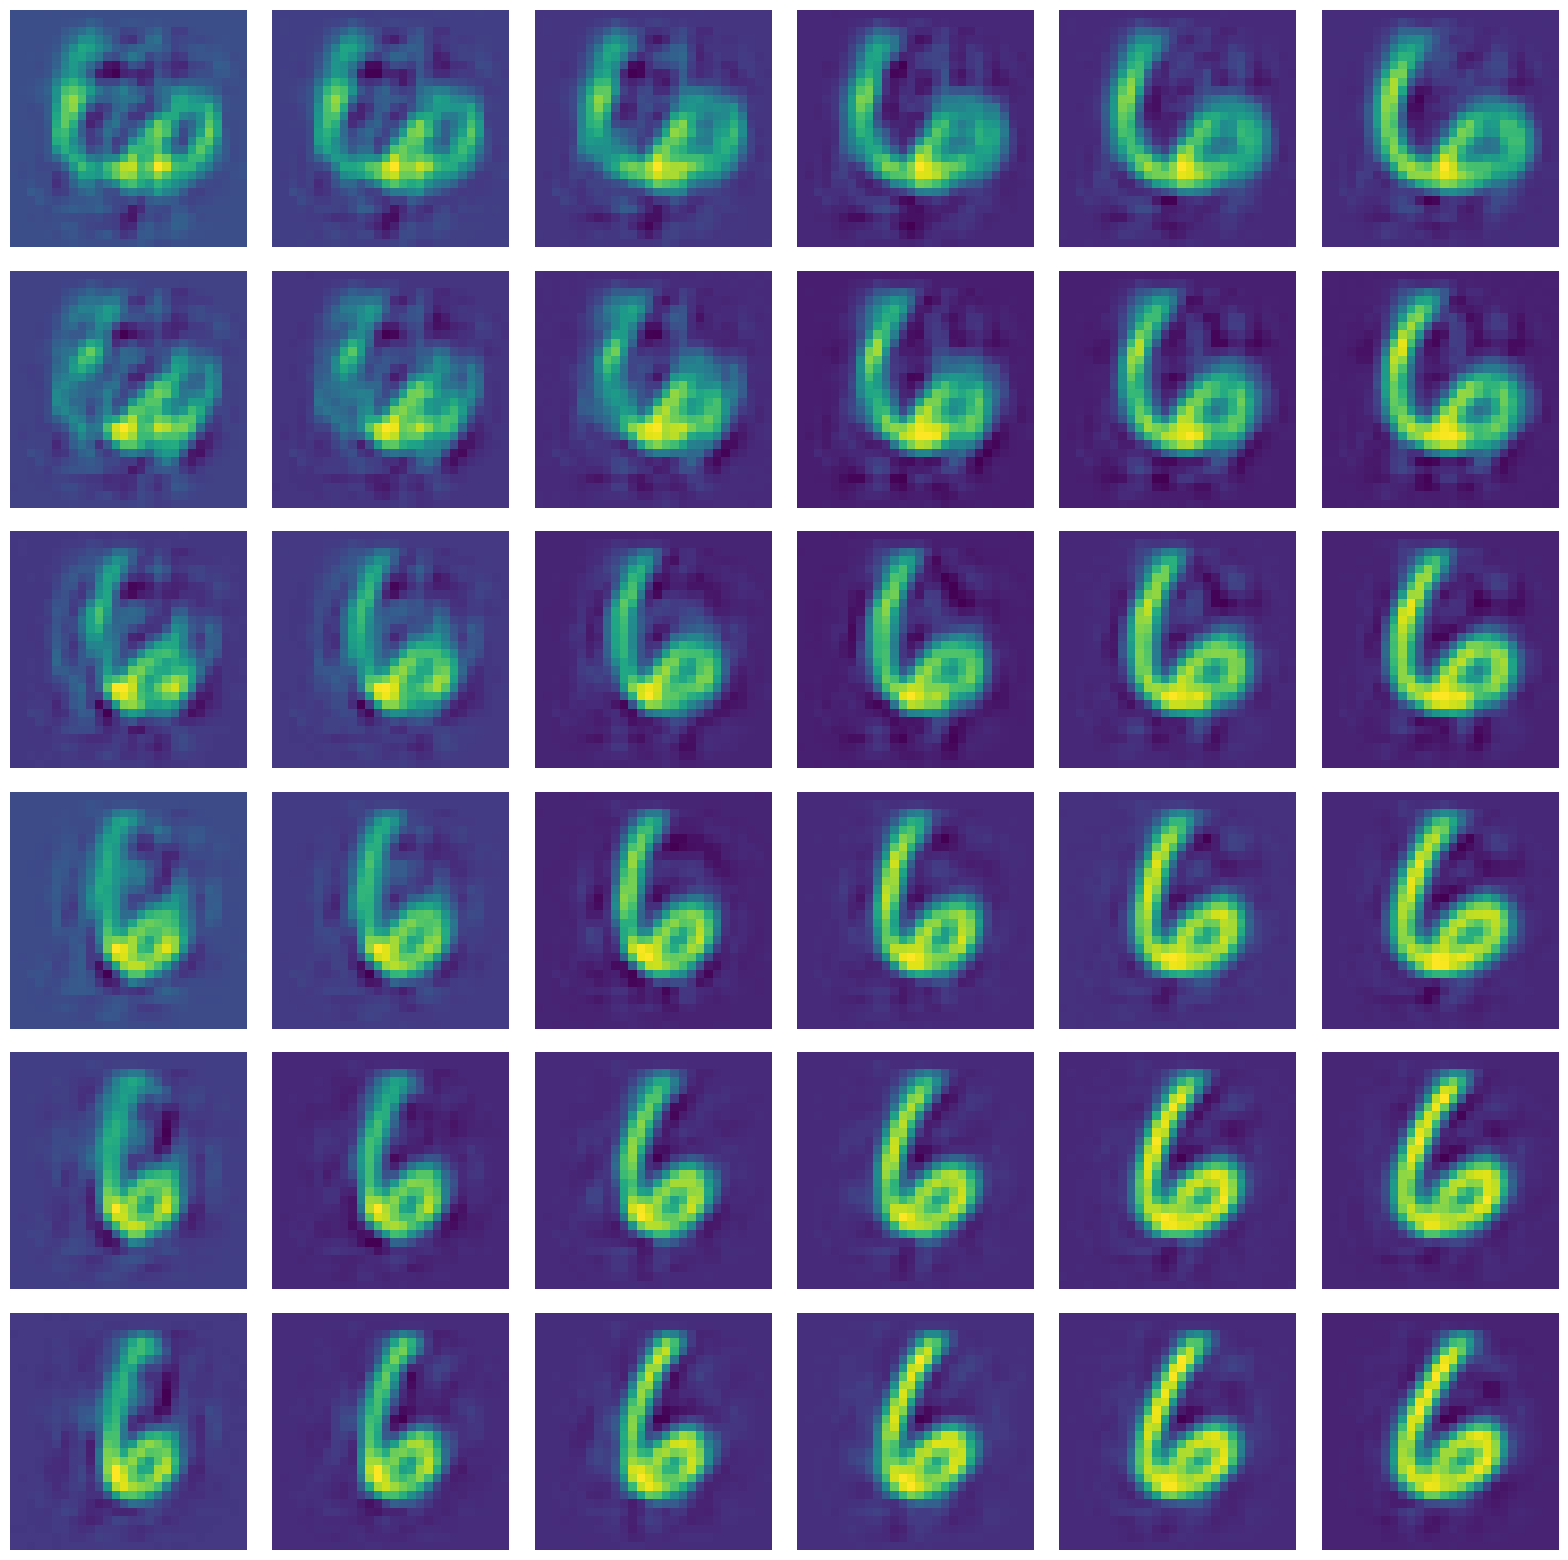

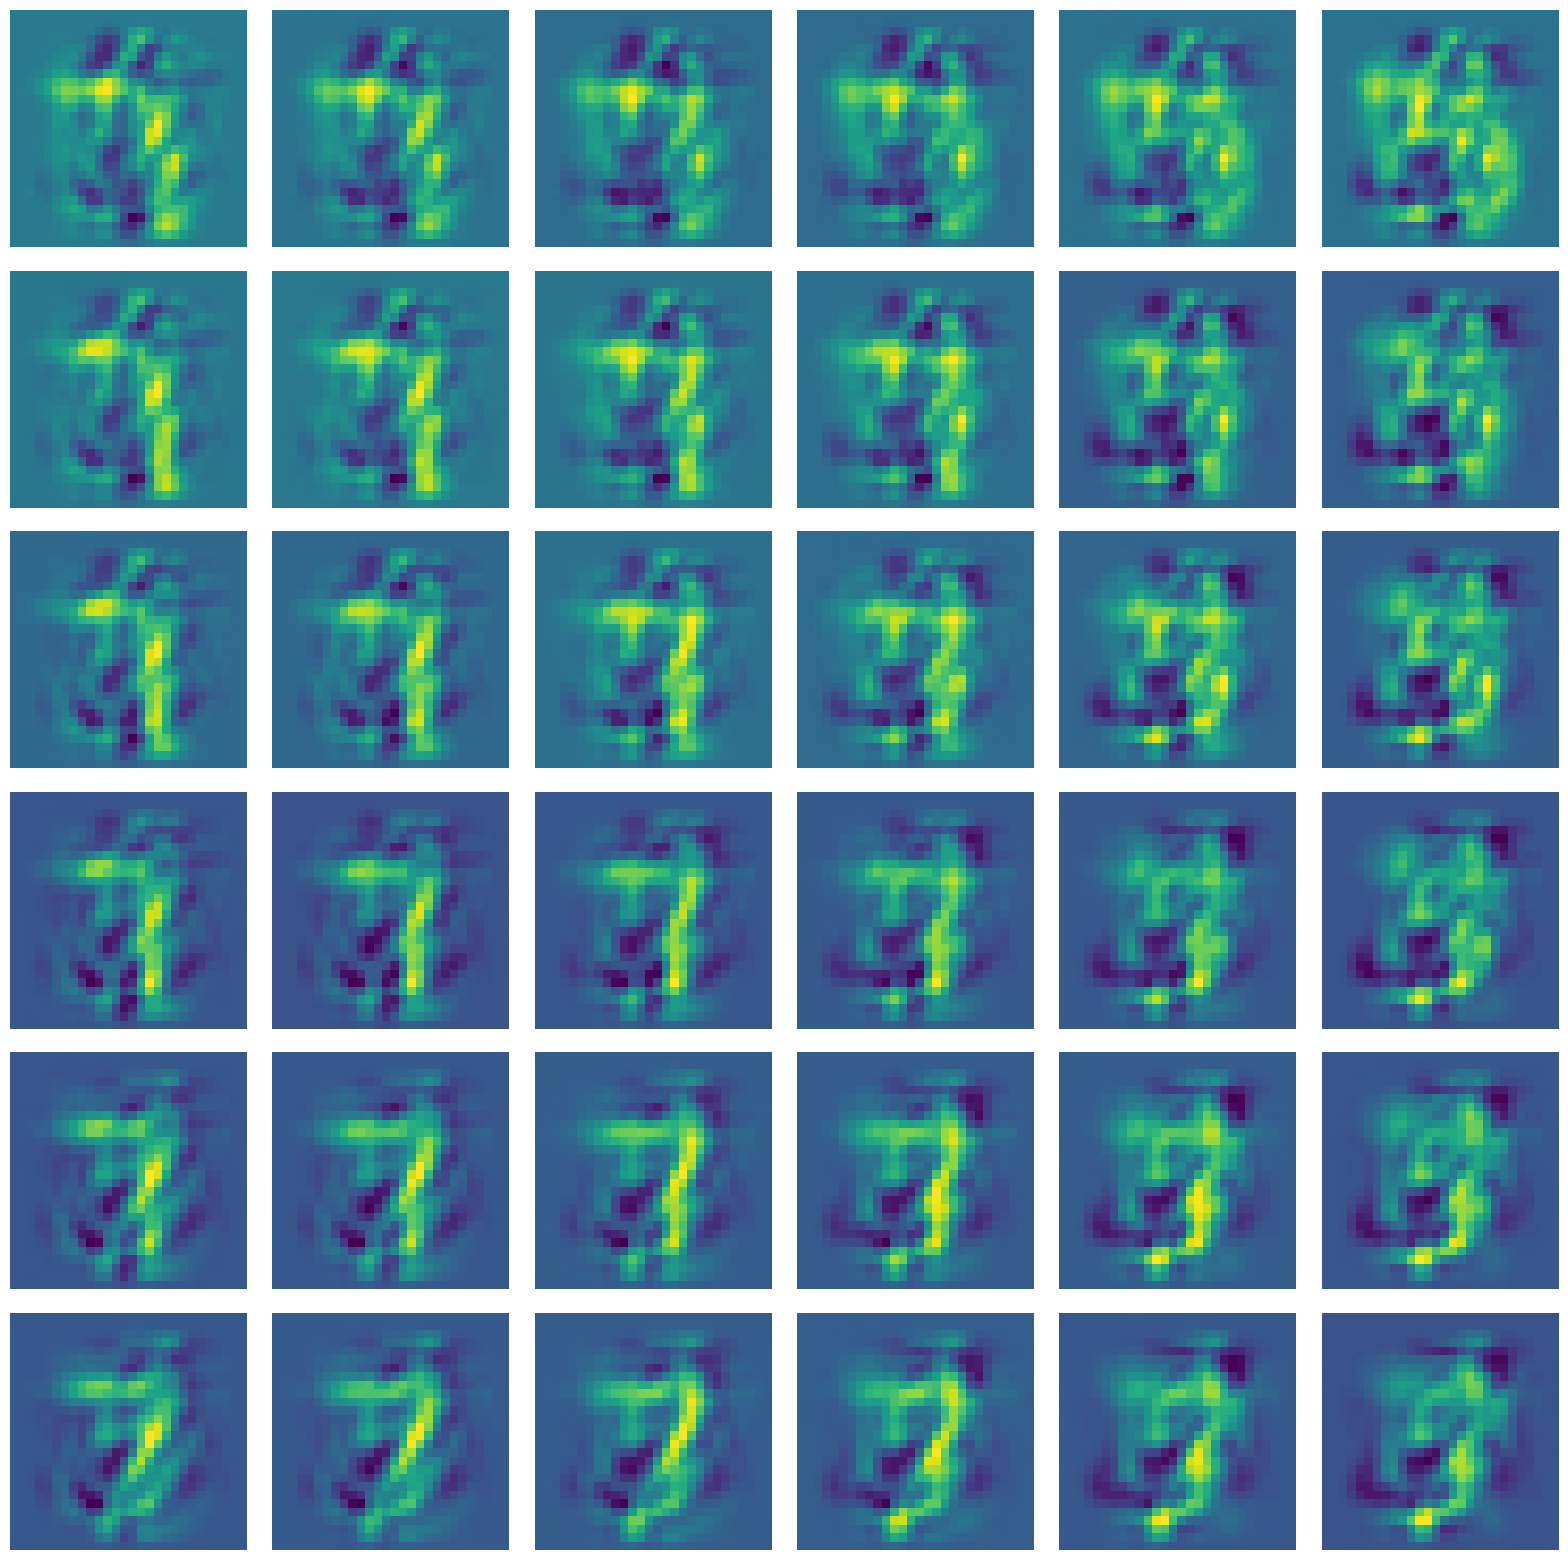

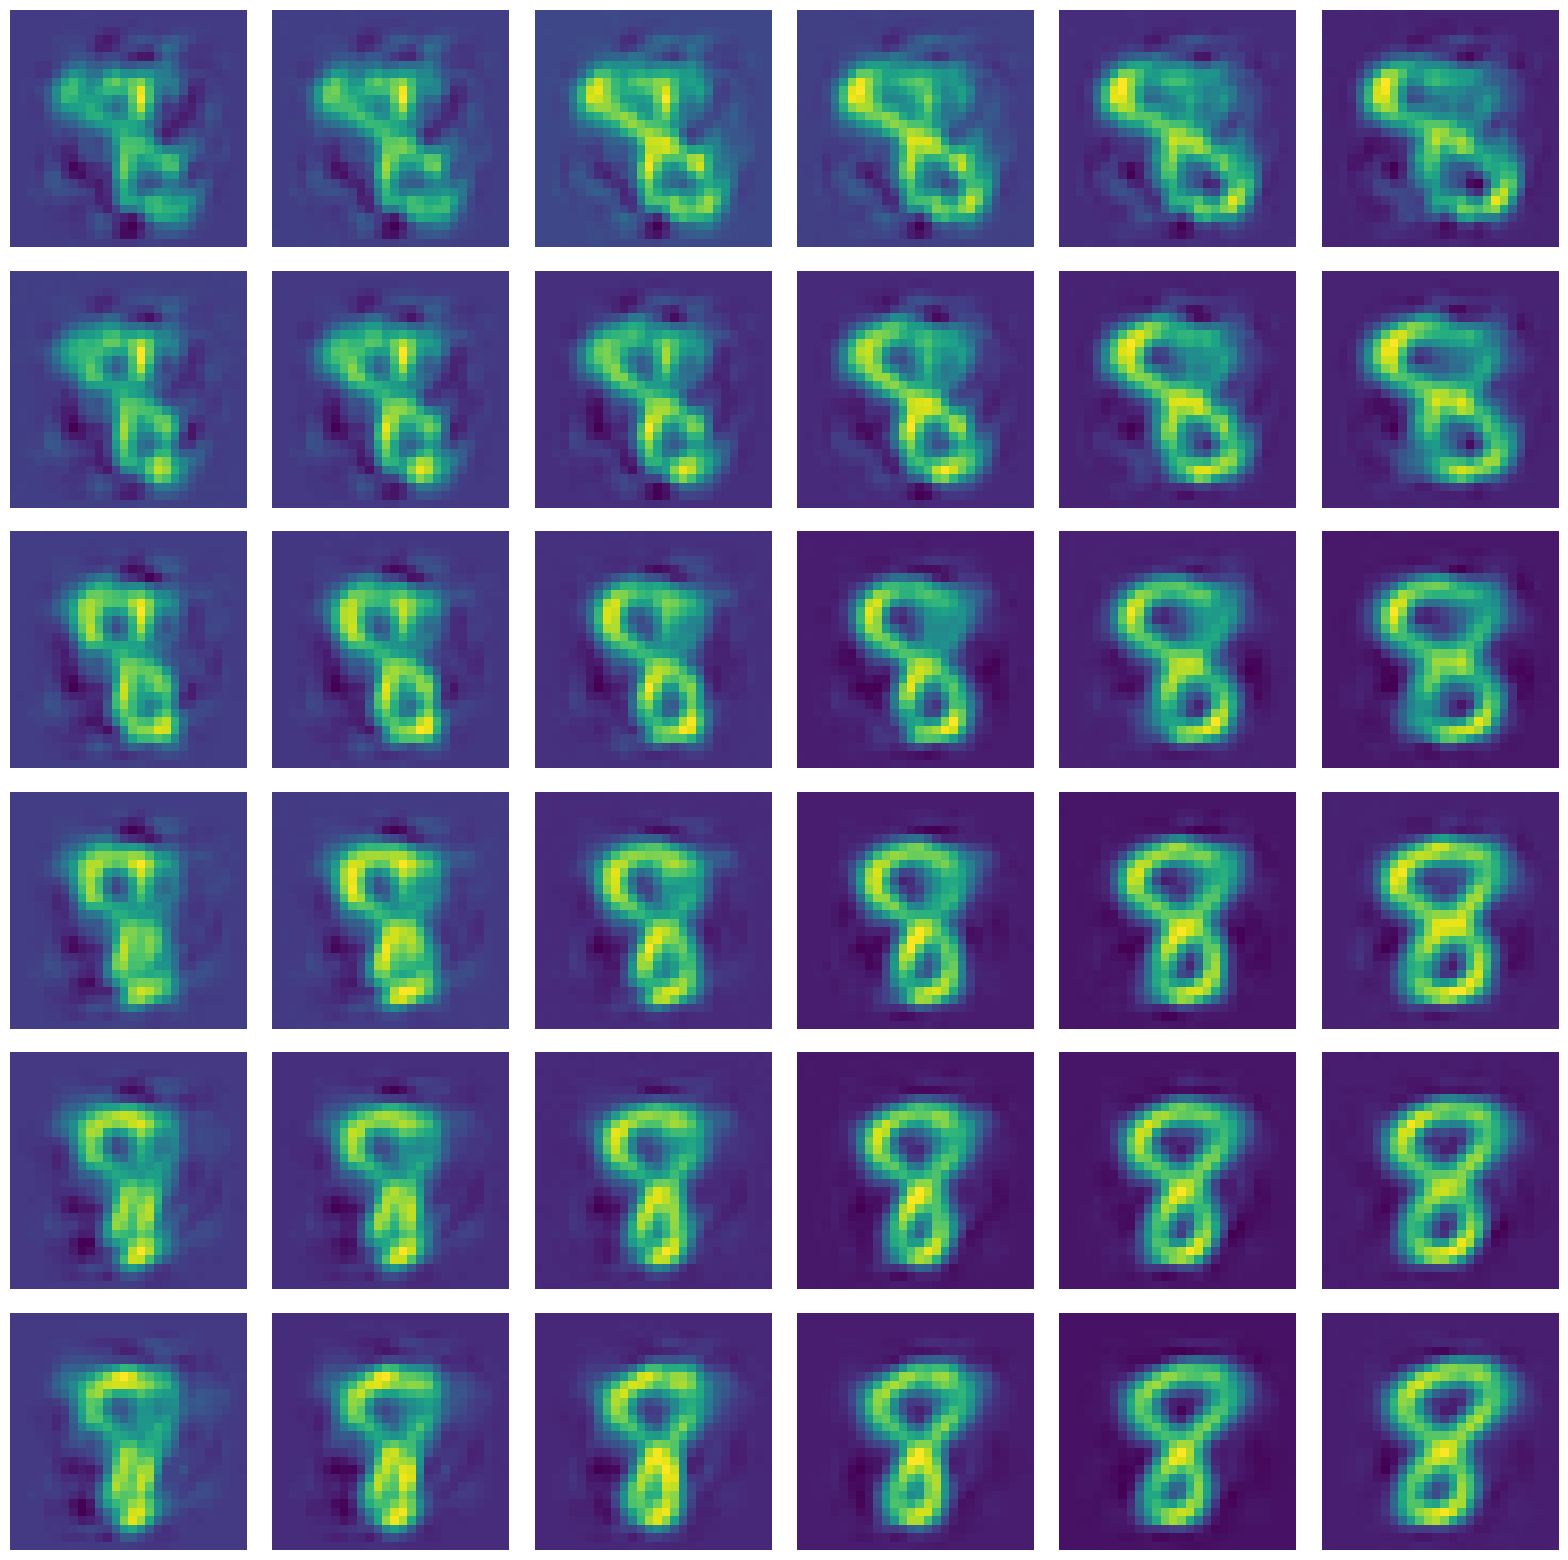

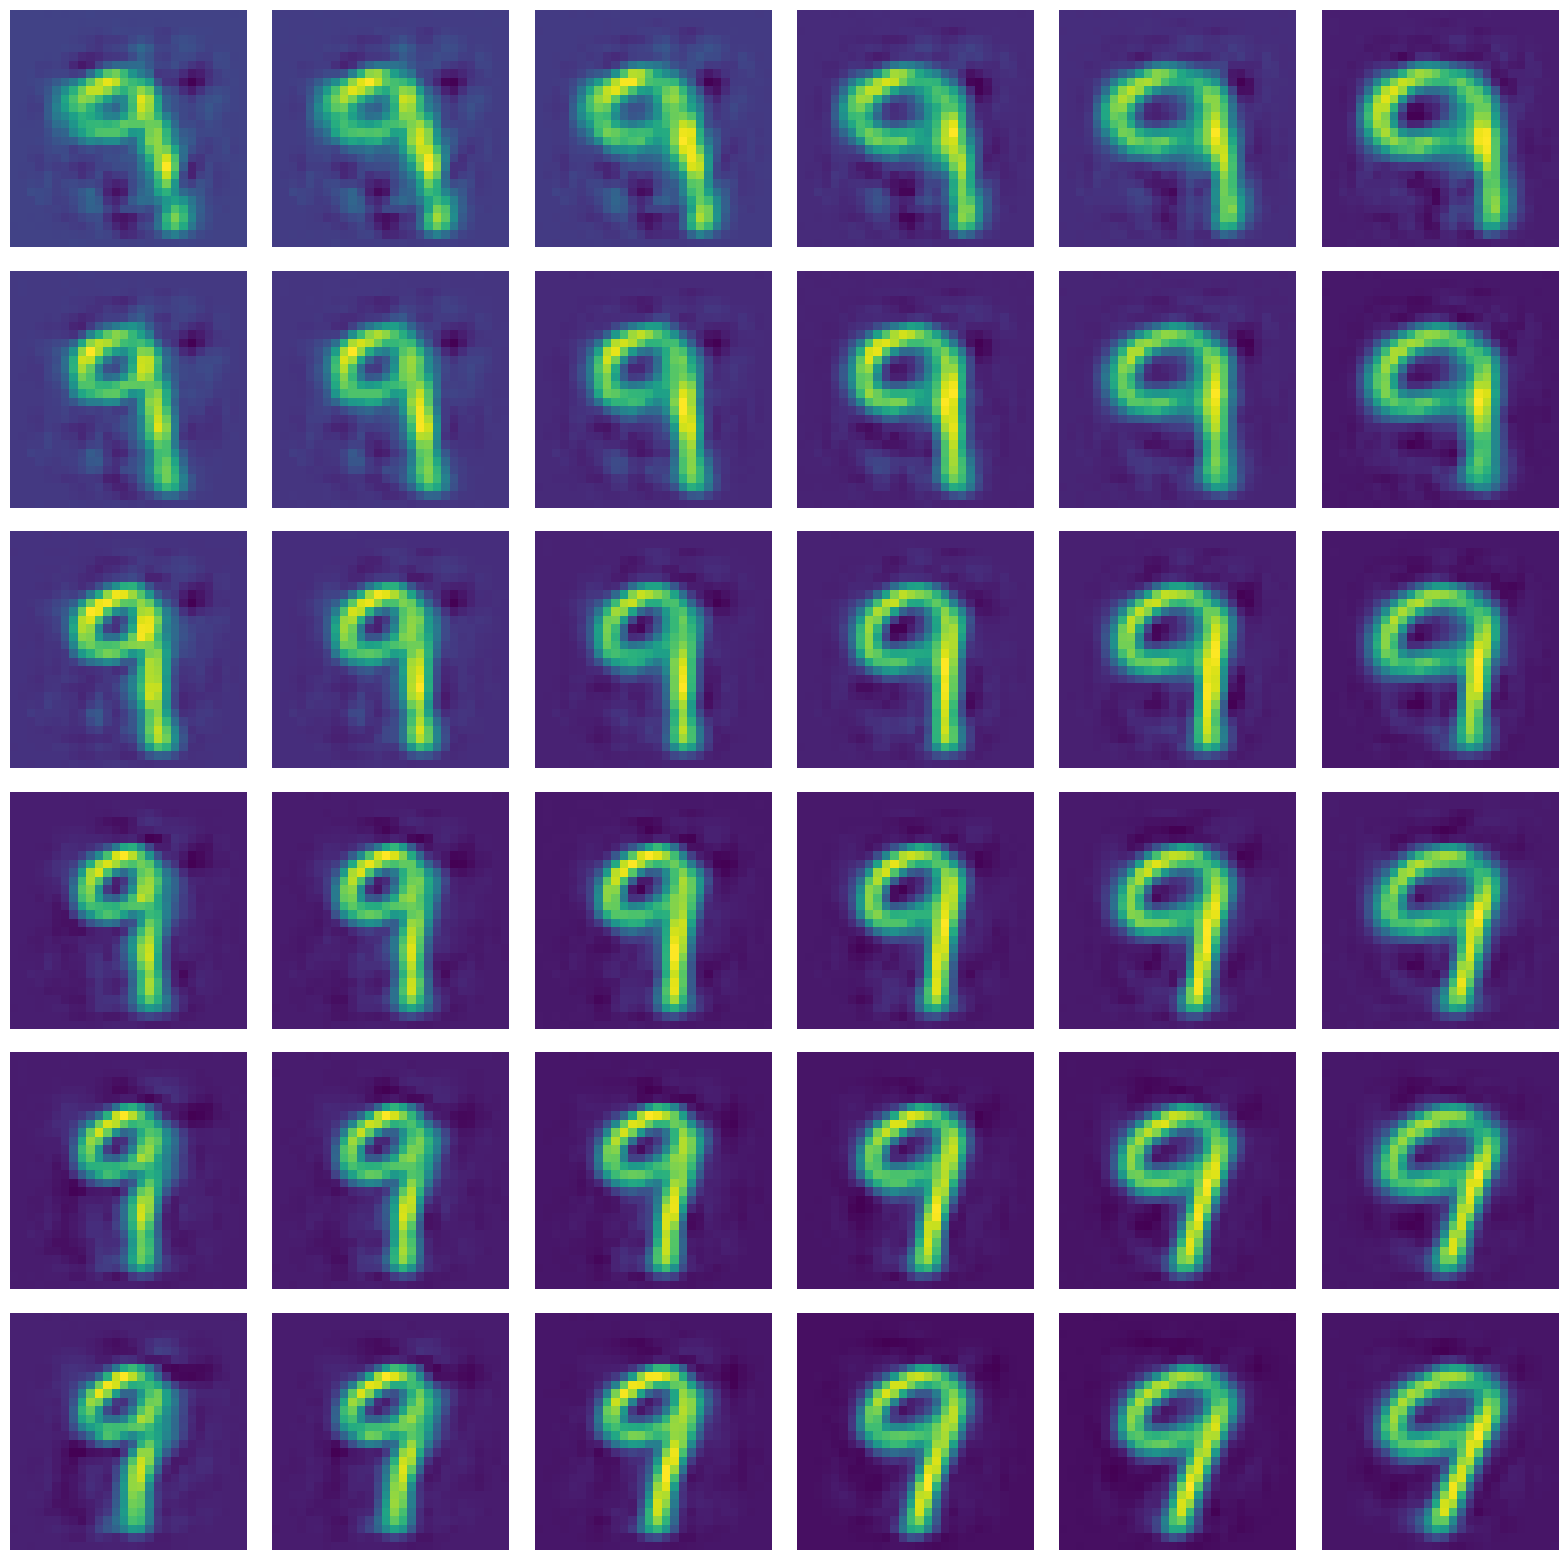

In [46]:
basis = np.identity(10)
steps = [2.0*x/10 for x in range(6)]
all = []
for v in basis:
    this_digit = []
    for c in combis(2, steps):
        this_digit.append(np.hstack([v, c]))
    res = decoder.predict(np.array(this_digit))
    show_digits(pd.DataFrame(res), len(steps), len(steps))
    all.extend(this_digit)
#res = decoder.predict(np.array(all))
#show_digits(pd.DataFrame(res), len(steps)**2, 10)

In [40]:
basis = decoder.predict(20*np.array(combis(n_latent, [0, 0.5, 1])))
show_digits(pd.DataFrame(basis), 9, basis.shape[0]//9)

14181/16608 [========================>.....] - ETA: 2s

KeyboardInterrupt: 